In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# enable duplicate lib to avoid kernel crash because of libiomp5md.dll (pytorch issue probably)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# Paths
RAW_DATA_DIR = 'data/raw/'
DATA_DIR = 'data/dataset/'
LOAD_DIR = 'data/processed/'
MODEL_SAVE_DIR = 'registery/'
FIGURES_DIR = 'figures/'
CLASSES = ['High', 'Low']

#### Create dataset from raw

In [4]:
from src.preprocessor import parse_combined_files
parse_combined_files(
    RAW_DATA_DIR + 'Audio/', CLASSES,
    RAW_DATA_DIR + 'Landmarks/', CLASSES,
    DATA_DIR,
)

Extracting features from audio and landmarks...
Processing High...
Processing High: 157/157 files (100.00% done)
Extracted features from High, done
Processing Low...
Processing Low: 170/170 files (100.00% done)
Extracted features from Low, done
Audio features extracted
Processing High...
[Error][7_129.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of NoneType
[Error][XDC3_197.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of NoneType
[Error][XDC3_198.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of NoneType
[Error][XDC3_199.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of NoneType
[Error][XDC3_200.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of NoneType
[Error][XDC3_201.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of NoneType
[Error][XDC3_202.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of NoneType
[Error][XDC3_203.obj_ibug68.ljson] Landmark extraction: Could not infer dtype of Non

In [5]:
# Load data
from src.preprocessor import load_processed_dataset
audio_data, landmarks_data, labels = load_processed_dataset(DATA_DIR)

In [6]:
print(f'Audio data shape: {audio_data.shape}')
print(f'Landmarks data shape: {landmarks_data.shape}')
print(f'Labels shape: {labels.shape}')

Audio data shape: (327, 64000)
Landmarks data shape: (327, 250, 3, 68)
Labels shape: (327,)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_audio_waveform(signal, sr=16000):
    time = np.linspace(0, len(signal) / sr, num=len(signal))
    plt.figure(figsize=(14, 5))
    plt.plot(time, signal)
    plt.title('Audio Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

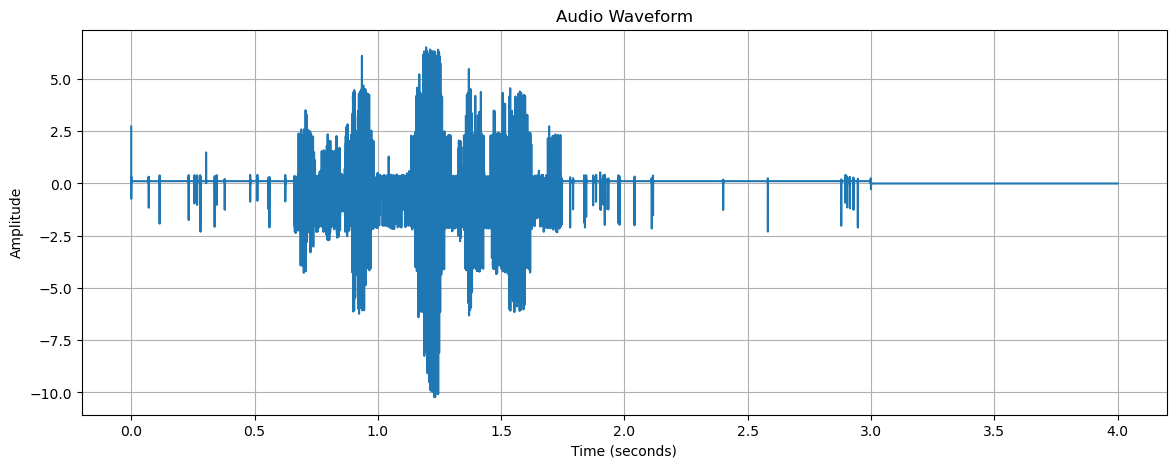

In [8]:
plot_audio_waveform(audio_data[0])

In [9]:
import plotly.graph_objects as go

# Define the outer and inner lip points (48 to 59 and 60 to 67, respectively). 
outer = np.transpose(landmarks_data[0,0,...,48:60])
inner = np.transpose(landmarks_data[0,0,...,60:68])
# Create closed loops by appending the first point at the end.
outer_line = np.vstack([outer, outer[0]])
inner_line = np.vstack([inner, inner[0]])

fig_interactive = go.Figure()

# Add outer lip trace (blue).
fig_interactive.add_trace(go.Scatter3d(
    x=outer_line[:, 0],
    z=outer_line[:, 1],
    y=outer_line[:, 2],
    mode='lines+markers',
    line=dict(color='blue', width=4),
    marker=dict(color='blue', size=6),
    name='Outer Lip'
))

# Add inner lip trace (red).
fig_interactive.add_trace(go.Scatter3d(
    x=inner_line[:, 0],
    z=inner_line[:, 1],
    y=inner_line[:, 2],
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(color='red', size=6),
    name='Inner Lip'
))

fig_interactive.update_layout(
    title="Interactive 3D Mouth Lip Edges",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    )
)

# turn off grid and axes and background
fig_interactive.update_layout(scene=dict(xaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
                             yaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title=''),
                             zaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, title='')))

fig_interactive.show()

### Alignment

In [10]:
from src.features import align_all_faces

In [11]:
aligned_landmarks = align_all_faces(landmarks_data)

In [12]:
aligned_landmarks.shape

(327, 250, 3, 68)

In [ ]:
import plotly.express as px

from src.features import landmark_connectivity_dictionary

In [ ]:

def plot_faces_from_samples(landmarks, frame_idx=None):
    """
    Aligns landmark data by the nose and plots one frame from each sample in an interactive 3D figure,
    with each sample's landmarks connected by thin lines. Dot markers are shown smaller.

    Parameters:
        landmarks: NumPy array of shape (T, 3, V).
        frame_idx: Index of the frame to plot from each sample. If None, the middle frame is used.
        nose_index: Index of the landmark corresponding to the nose tip (used for alignment).
    """
    

    T, C, V = landmarks.shape
    if frame_idx is None:
        frame_idx = T // 2

    # Define facial segments
    segments = landmark_connectivity_dictionary()
    closed_segments = {"Right Eye", "Left Eye", "Outer Lip", "Inner Lip"}

    # Generate a color for each frame using the Viridis colorscale.
    colors = px.colors.sample_colorscale(
        "Viridis", [i / (T - 1) if T > 1 else 0.5 for i in range(T)]
    )

    fig = go.Figure()

    # Plot each frame's landmarks.
    for i in range(T):
        face = landmarks[i, :, :]  # shape (3, V)
        x_all = face[0, :]
        y_all = face[1, :]
        z_all = face[2, :]
        color = colors[i]

        for segment_name, indices in segments.items():
            x = x_all[indices]
            y = y_all[indices]
            z = z_all[indices]
            if segment_name in closed_segments:
                # Close the loop by appending the first coordinate.
                x = np.concatenate([x, [x[0]]])
                y = np.concatenate([y, [y[0]]])
                z = np.concatenate([z, [z[0]]])
                
            fig.add_trace(
                go.Scatter3d(
                    x=x,
                    y=y,
                    z=z,
                    mode='lines+markers',
                    marker=dict(size=1, color=color),
                    line=dict(width=1, color=color),
                    name=f"Frame {i+1}" if i == 0 else "",
                    showlegend=(i == 0)
                )
            )

    fig.update_layout(
        title="Aligned Facial Landmarks (3D, Nose-Centered)",
        scene=dict(
            xaxis=dict(title="X Coordinate", showgrid=False, zeroline=False, visible=False),
            yaxis=dict(title="Y Coordinate", showgrid=False, zeroline=False, visible=False),
            zaxis=dict(title="Z Coordinate", showgrid=False, zeroline=False, visible=False),
            camera=dict(eye=dict(x=0, y=0, z=2))
        )
    )
    fig.show()


In [68]:
plot_faces_from_samples(aligned_landmarks[2])

In [64]:
plot_faces_from_samples(landmarks_data[0])

In [13]:
from src.preprocessor import save_processed_dataset
save_processed_dataset(audio_data, aligned_landmarks, labels, LOAD_DIR)

Processed dataset saved to data/processed/


#### Audio Feature Exploration

In [15]:
from src.preprocessor import load_processed_dataset
audio_data, landmarks_data, labels = load_processed_dataset(LOAD_DIR)

In [19]:
from src.features import audio_features

In [21]:
audio_feat = audio_features(audio_data)

In [22]:
audio_feat.shape

(327, 23)

In [27]:
len(audio_feat[..., 22])

327

In [28]:
np.save(LOAD_DIR + 'audio_static_feat.npy', audio_feat)

In [64]:
LOAD_DIR = 'data/processed/'
import numpy as np
from src.preprocessor import load_processed_dataset
from src.features import audio_features
audio_data, landmarks_data, labels = load_processed_dataset(LOAD_DIR)
audio_feat = audio_features(audio_data, static=False)
print(f'audio_feat shape: {audio_feat.shape}')
np.save(LOAD_DIR + 'audio_dynamic_feat.npy', audio_feat)

audio_feat shape: (327, 126, 23)


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [ ]:
feature_names = [
    'Root_Mean_Square', 'Spectral_Flux', 'Zero_Crossing_Rate',
]

mfcc_features = [f'MFCC_{i}' for i in range(0, 20)]
feature_names = mfcc_features + feature_names

df = pd.DataFrame(audio_feat, columns=feature_names)
df['Label'] = labels
df['Label'] = df['Label'].map({0: 'Fluent', 1: 'Non-Fluent'})
print(df.head())


      MFCC_0     MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6  \
0 -69.224068  22.043453 -3.036118  5.264224 -1.720383  0.617928 -3.053530   
1 -20.433596  31.535559 -6.168454  4.738346 -5.685060  1.269470 -3.268860   
2 -90.396767  24.045973 -8.561428  1.236891 -1.464915  2.942212 -1.939615   
3 -80.797493  17.530411  2.427690  7.861257 -0.026413 -0.666162 -1.227769   
4 -62.268780  23.930510 -3.587806  4.721196 -1.599490  0.999575 -0.223759   

     MFCC_7    MFCC_8    MFCC_9  ...   MFCC_14   MFCC_15   MFCC_16   MFCC_17  \
0  1.693774 -1.691132  2.754958  ... -1.394104  2.690516 -0.315732  2.366081   
1 -1.701599 -3.641308  0.832609  ... -3.536220  1.724492 -2.047241  1.875218   
2  0.181592 -0.187203  3.597183  ... -2.431692  2.768832 -0.493333  2.998093   
3  0.317386 -2.557230  2.658521  ... -0.639556  2.933410 -1.668394  2.252869   
4  0.123535 -0.984717  2.589846  ... -2.012434  2.622015 -0.903921  2.381938   

    MFCC_18   MFCC_19  Root_Mean_Square  Spectral_Flux  

In [ ]:
grouped = df.groupby('Label')
print(grouped.describe())


           MFCC_0                                                             \
            count        mean        std         min         25%         50%   
Label                                                                          
Fluent      157.0 -124.056779  83.474056 -297.213013 -198.211472 -111.796921   
Non-Fluent  170.0 -125.135708  68.220063 -315.512787 -185.286587 -109.632797   

                                 MFCC_1             ... Spectral_Flux  \
                  75%        max  count       mean  ...           75%   
Label                                               ...                 
Fluent     -69.303864  75.382355  157.0  32.002195  ...      1.814985   
Non-Fluent -70.568600   9.000296  170.0  35.089085  ...      1.875125   

                     Zero_Crossing_Rate                                \
                 max              count      mean       std       min   
Label                                                                   
Fluent      2.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


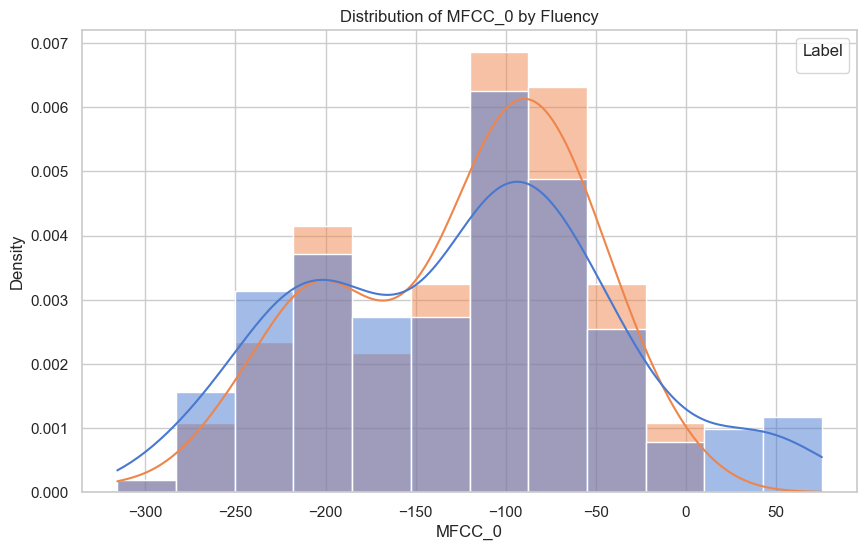

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


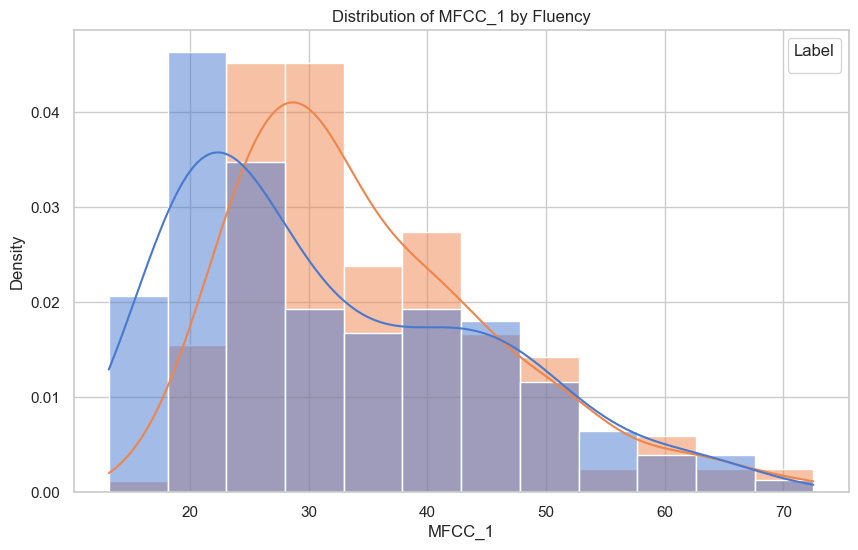

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


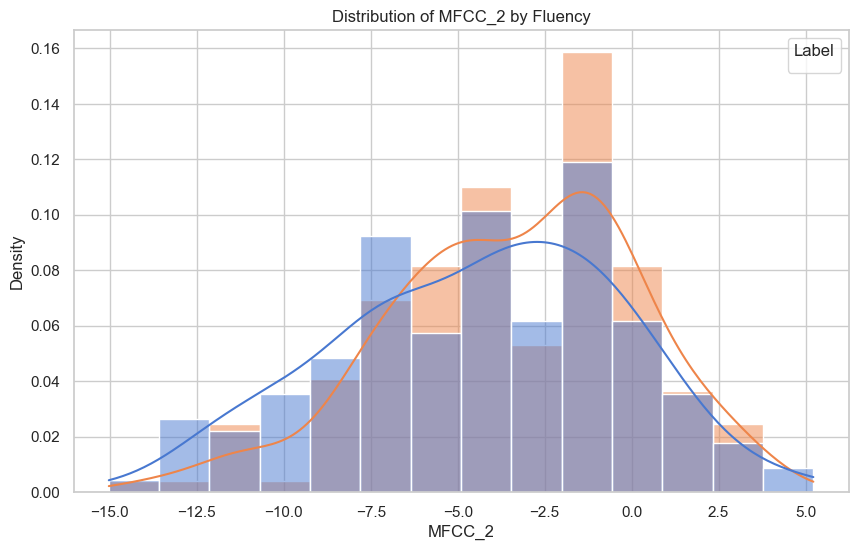

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


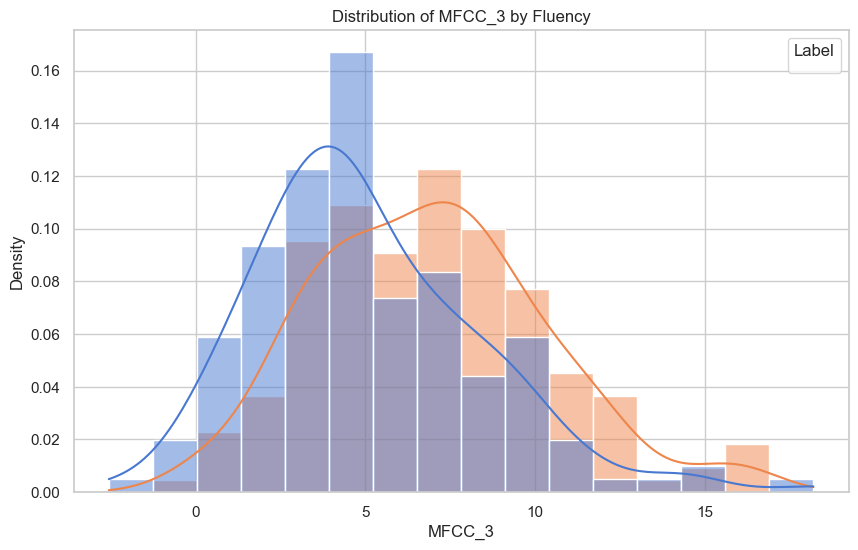

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


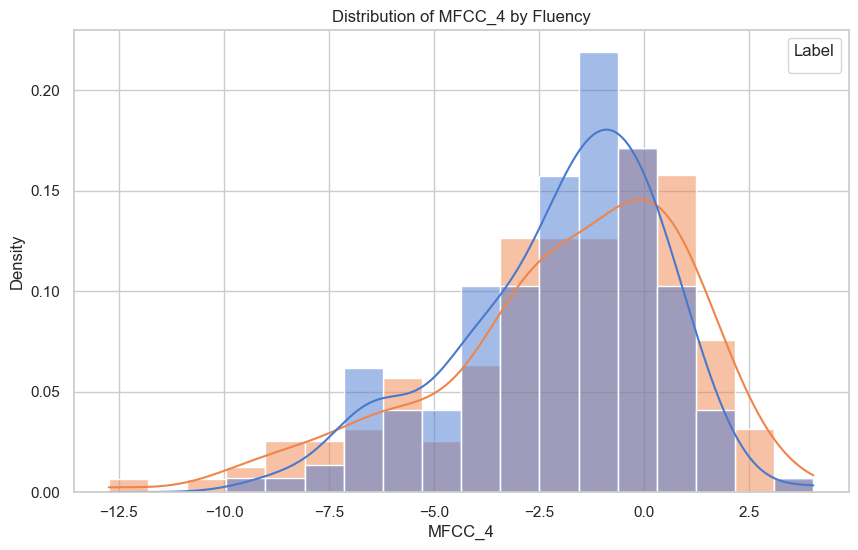

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


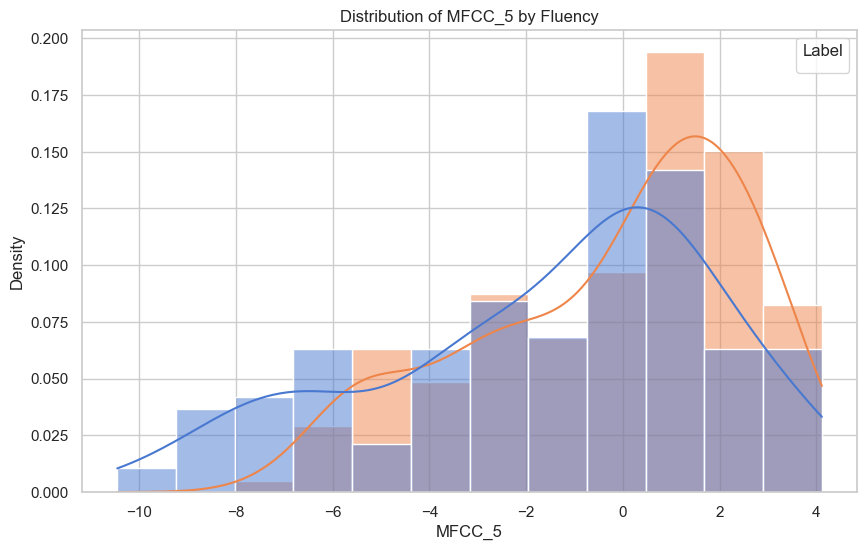

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


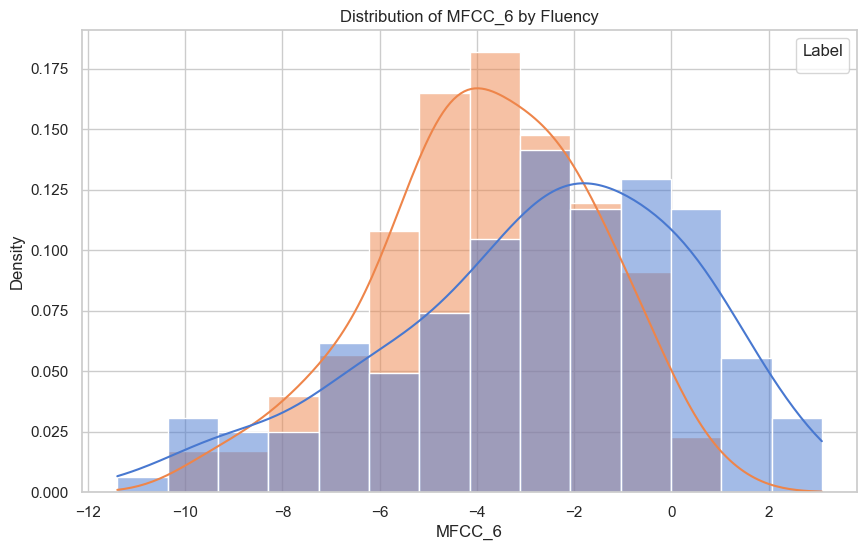

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


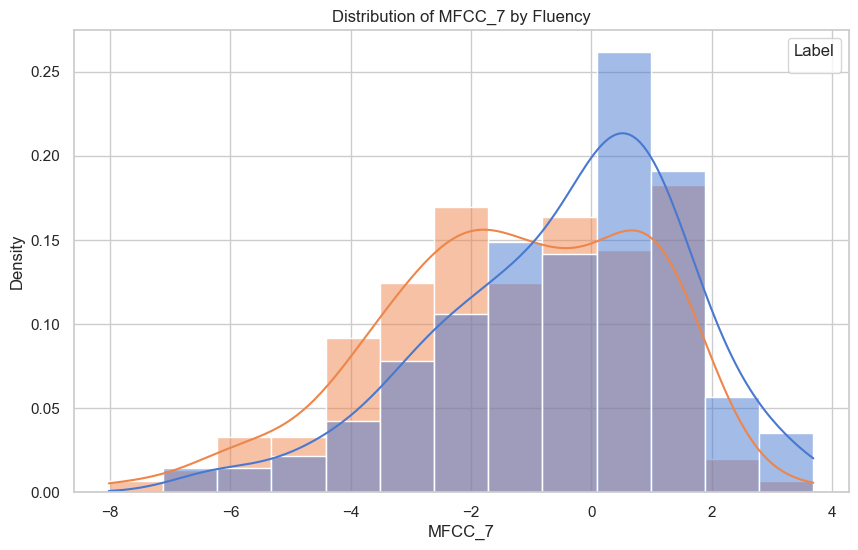

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


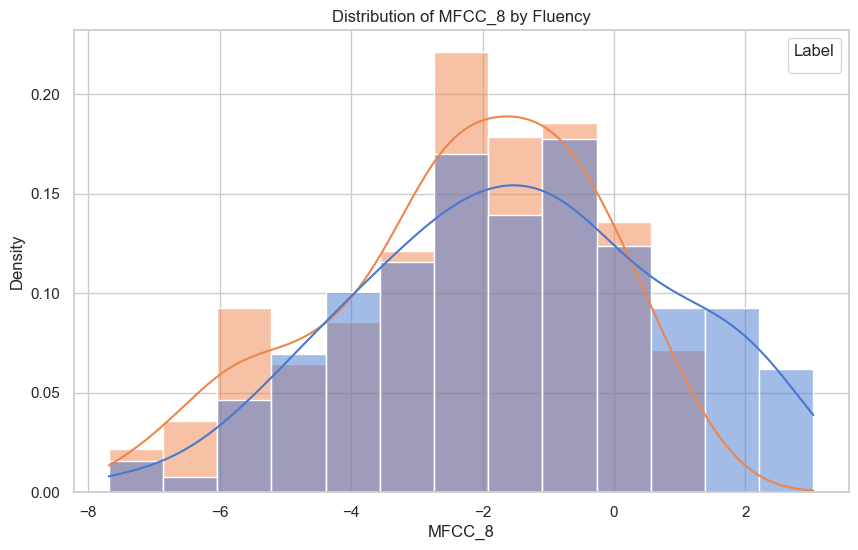

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


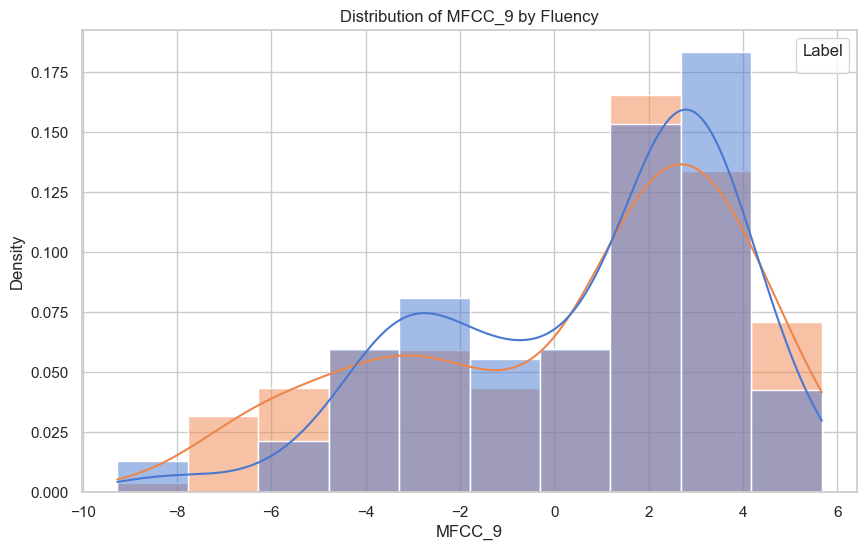

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


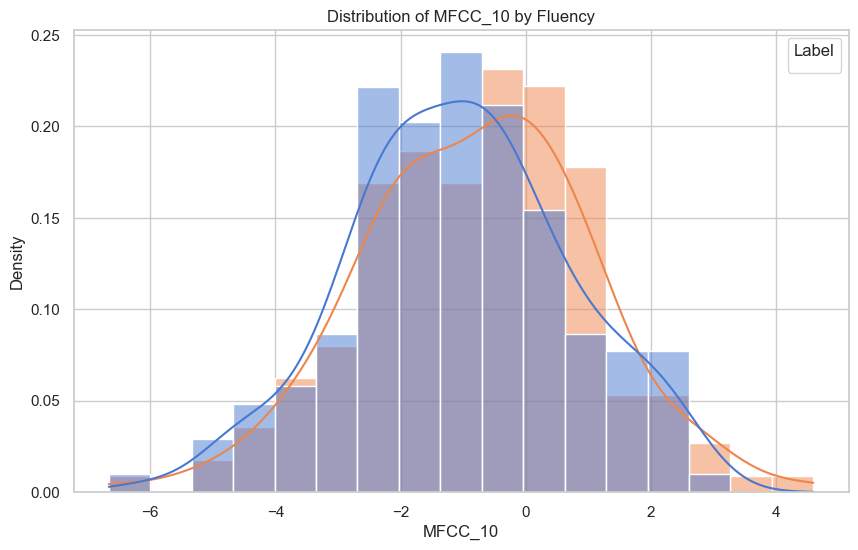

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


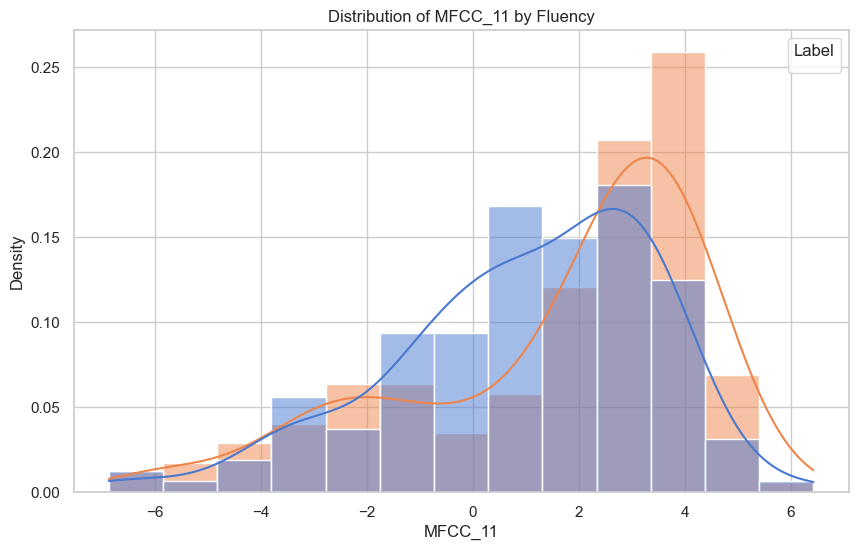

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


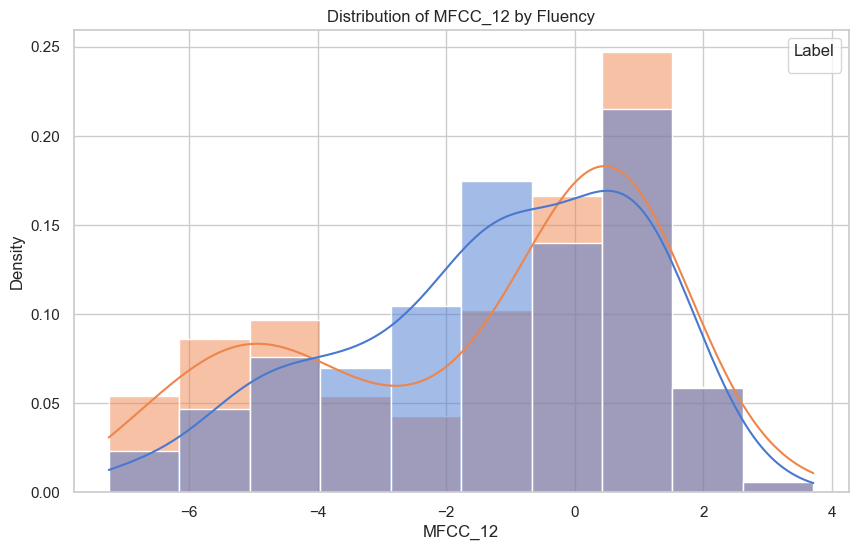

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


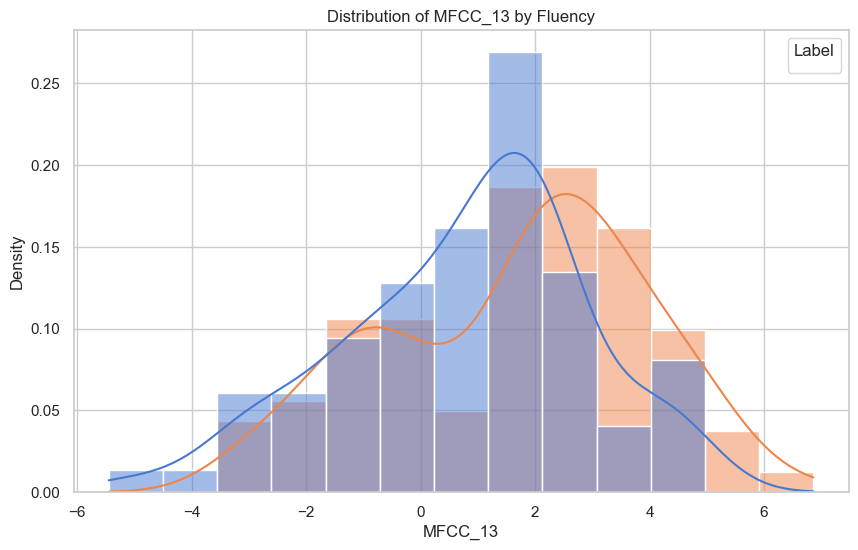

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


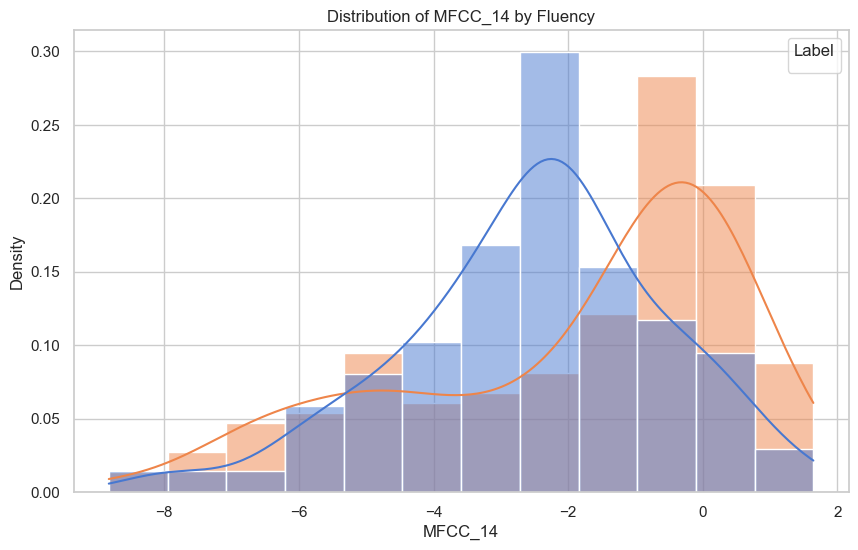

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


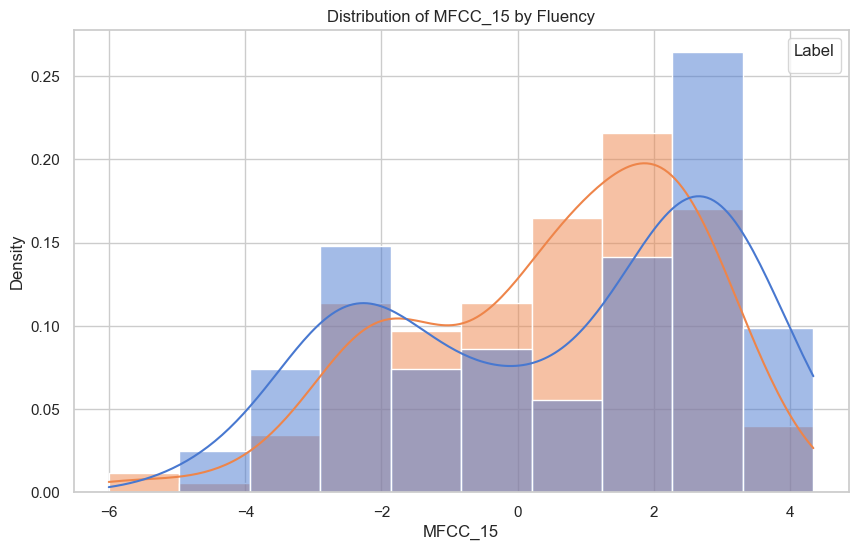

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


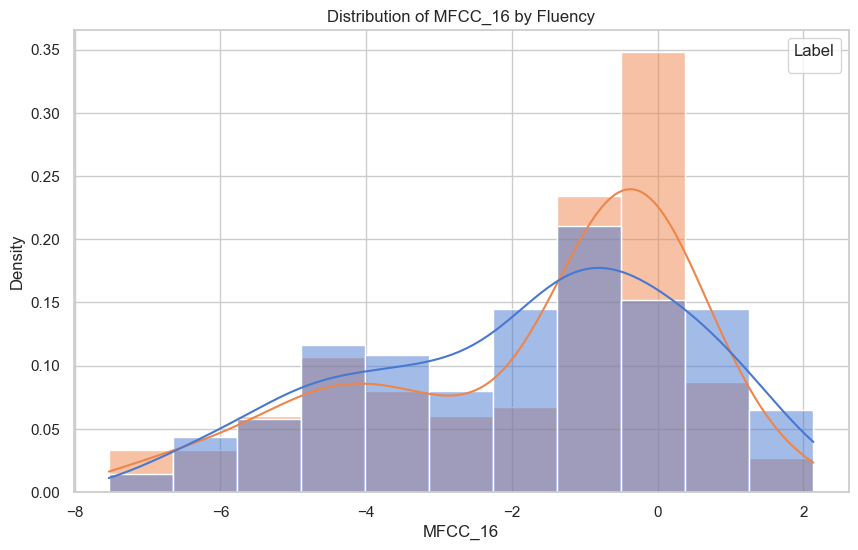

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


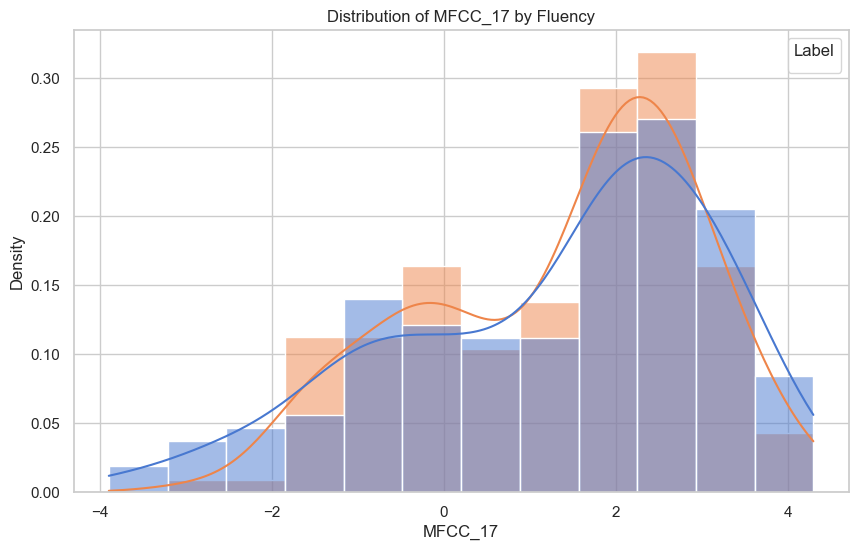

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


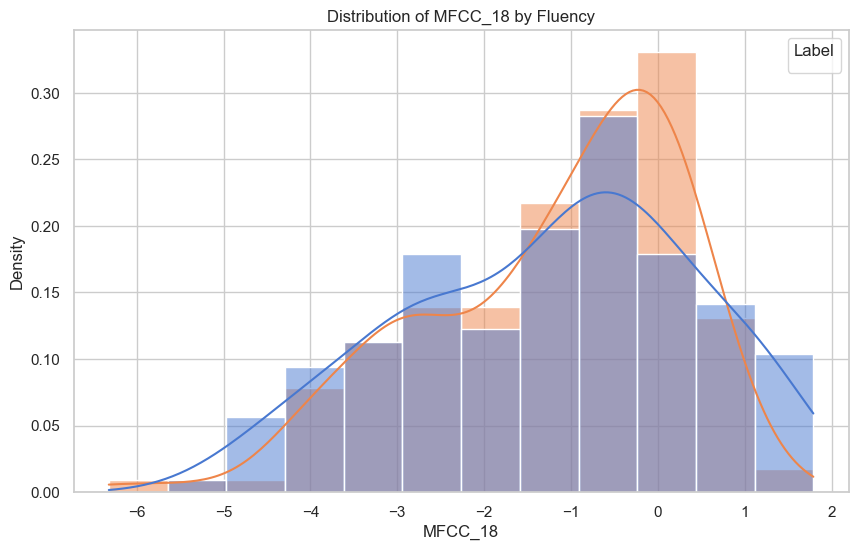

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


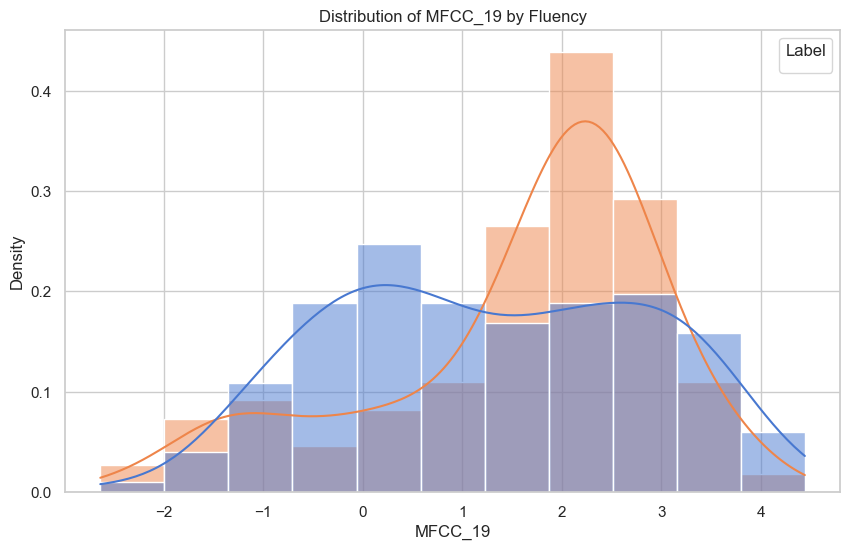

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


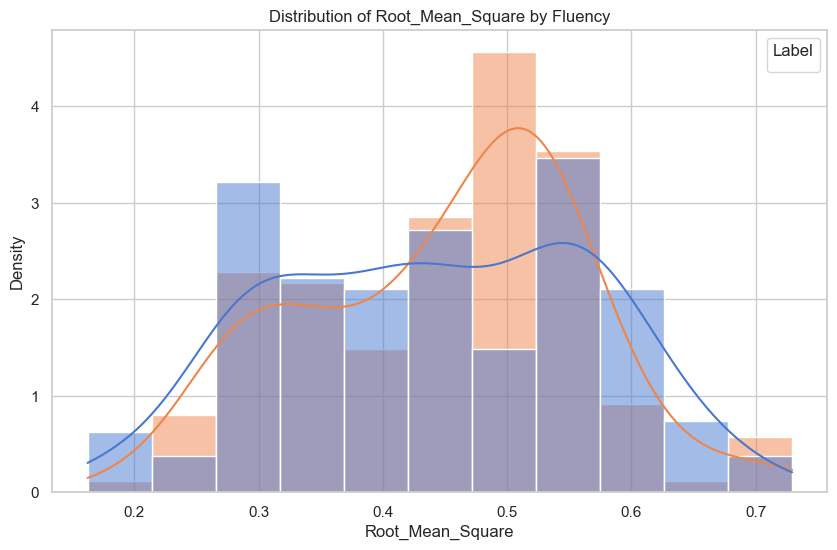

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


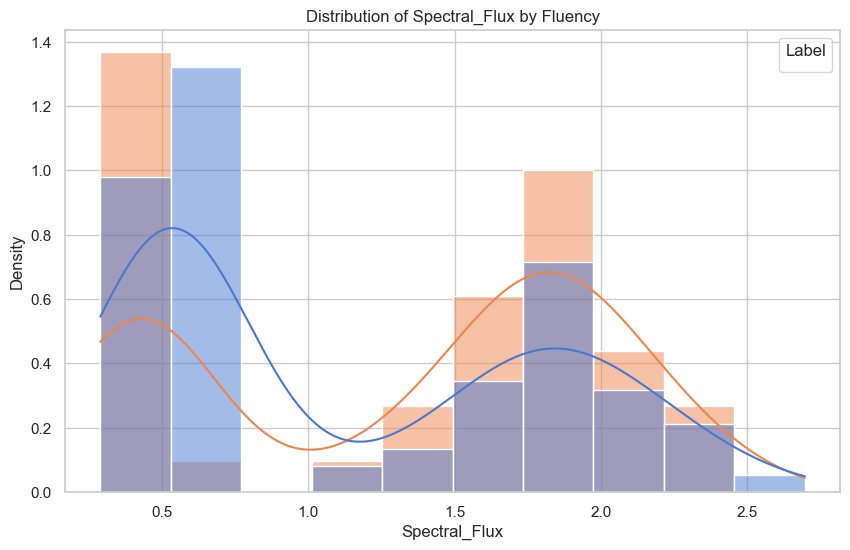

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


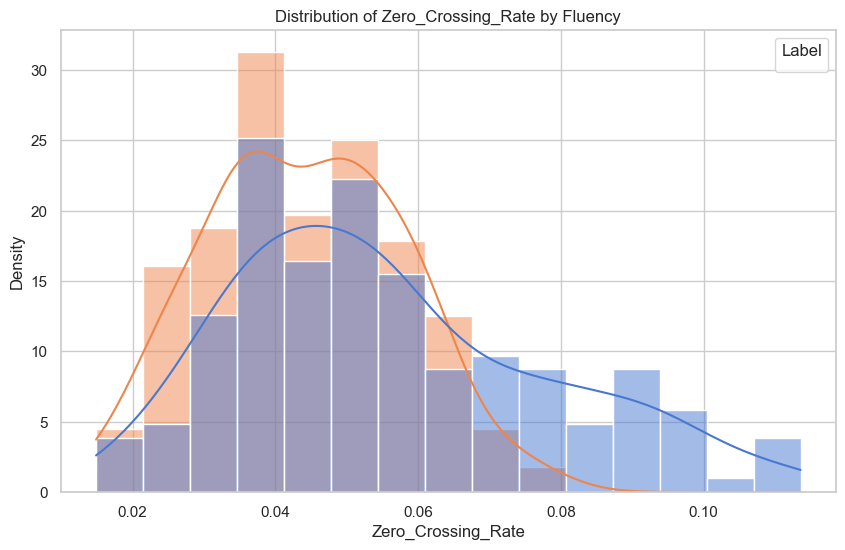

In [ ]:
sns.set(style='whitegrid', palette='muted', color_codes=True)
%matplotlib inline

# Plot histograms for each feature
for feature in feature_names:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue='Label', kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {feature} by Fluency')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend(title='Label')
    plt.show()


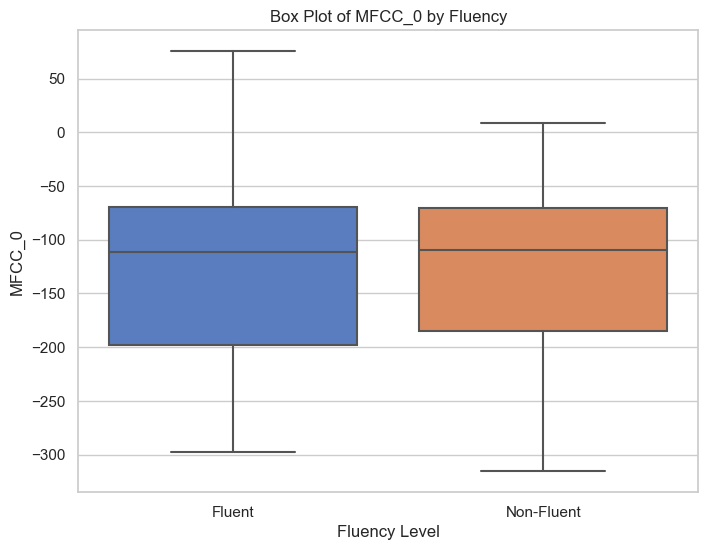

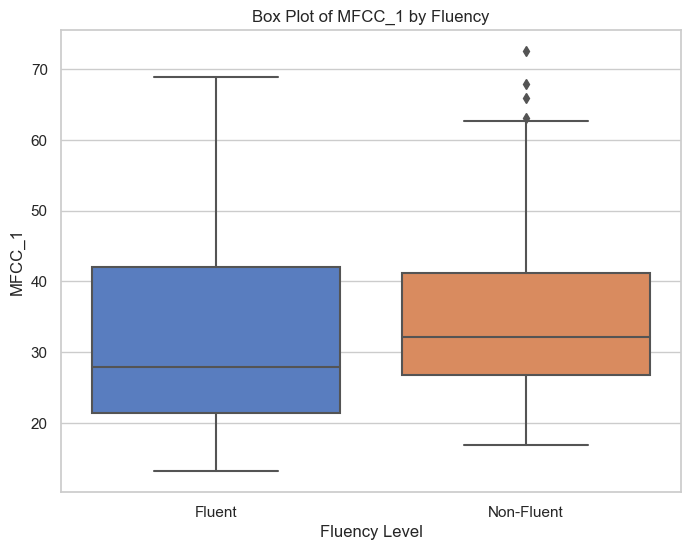

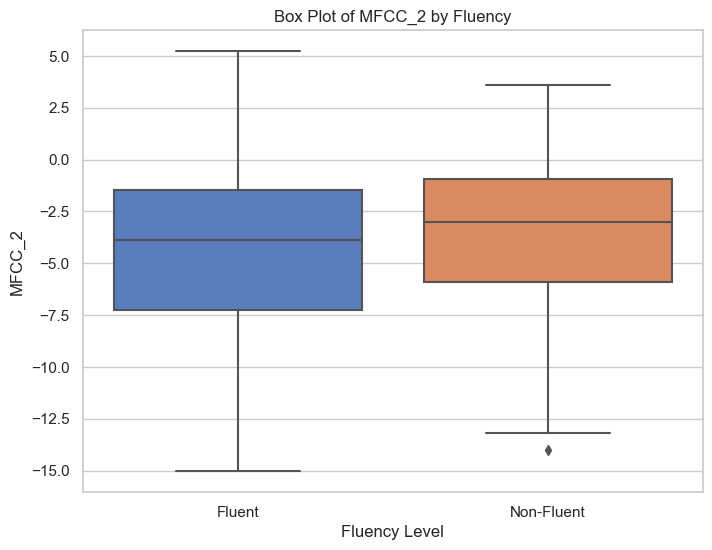

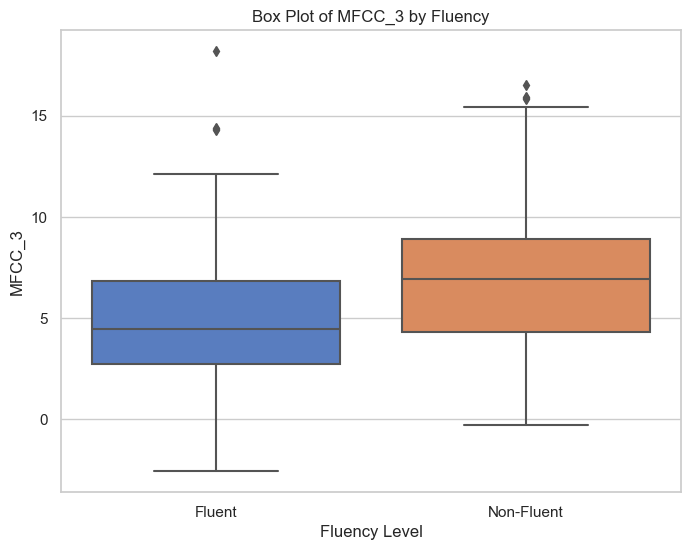

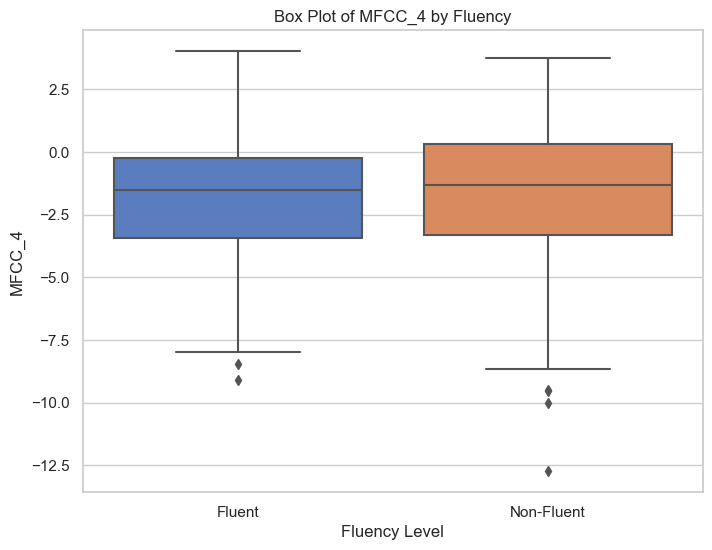

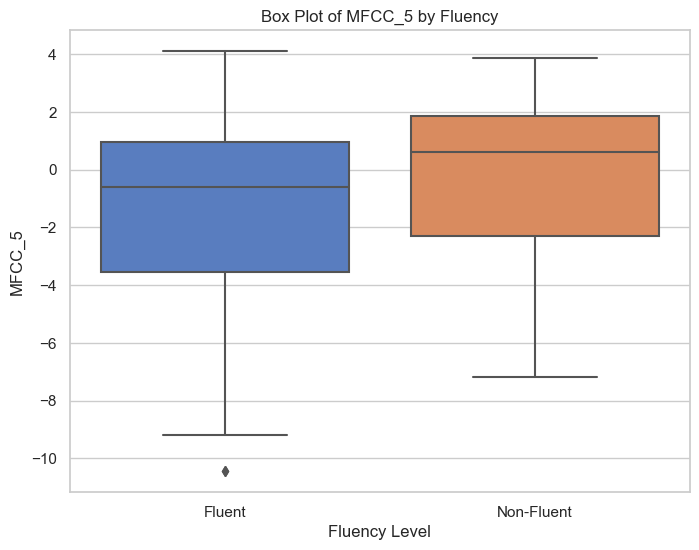

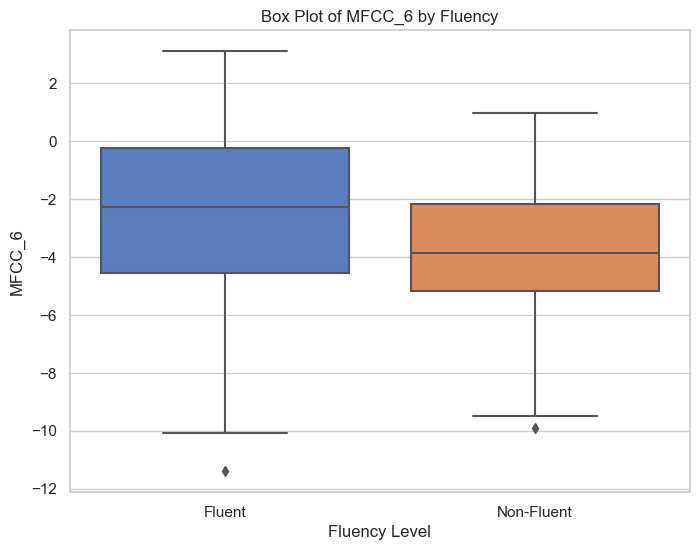

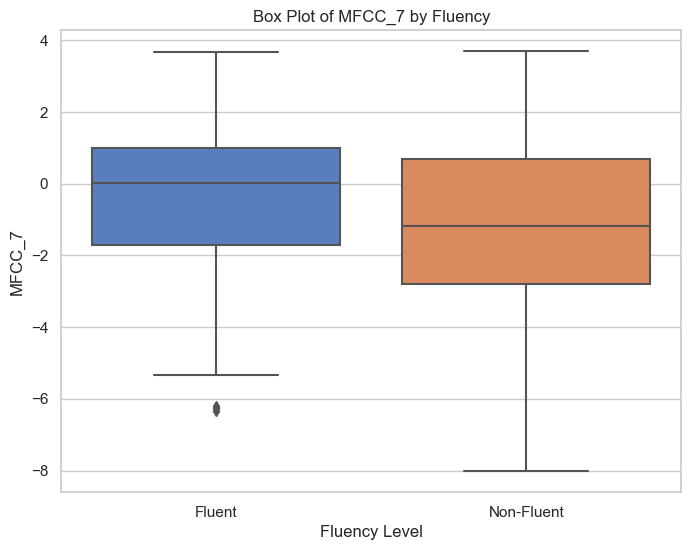

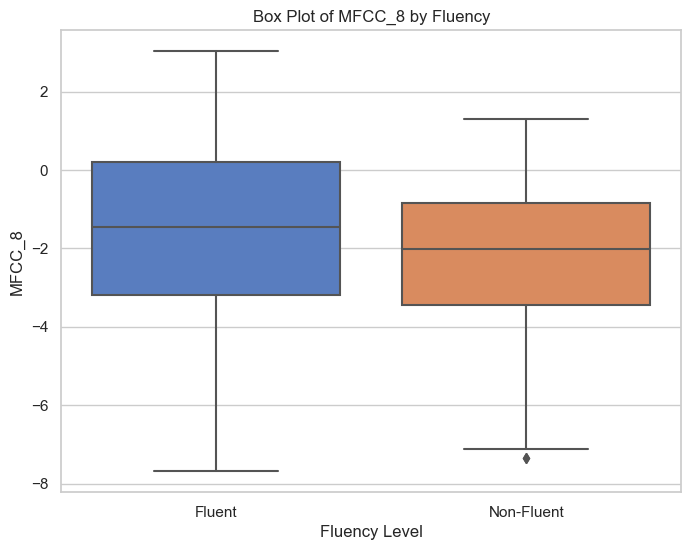

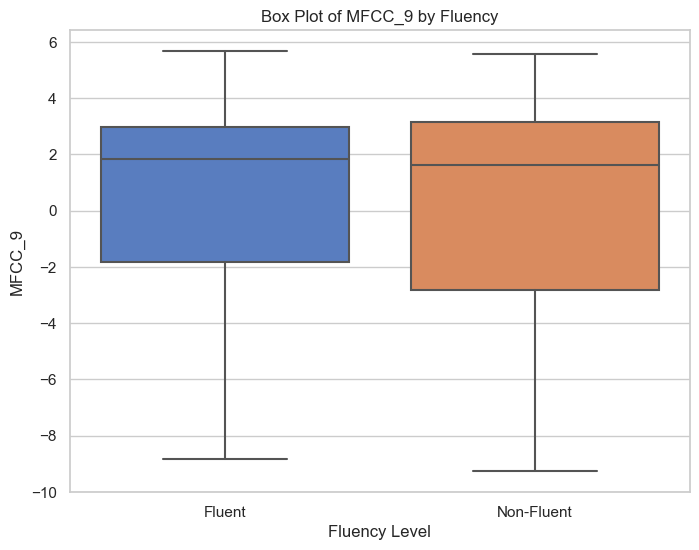

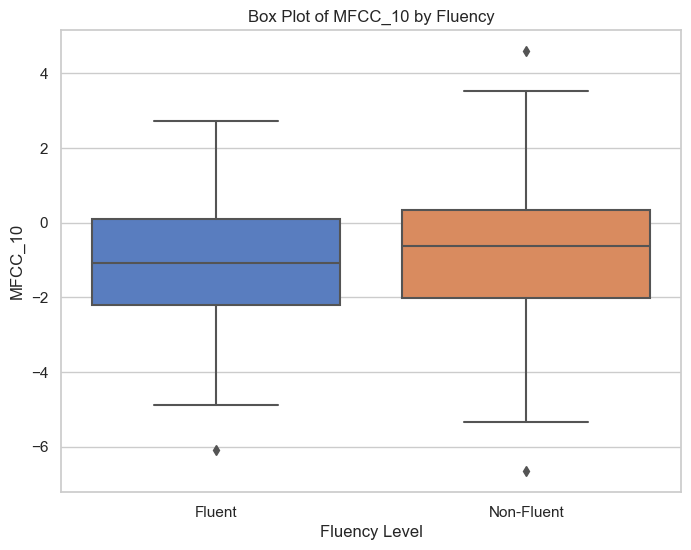

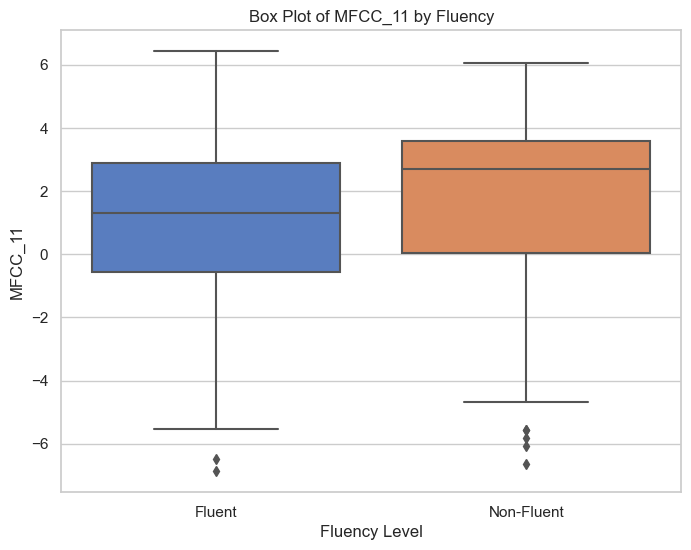

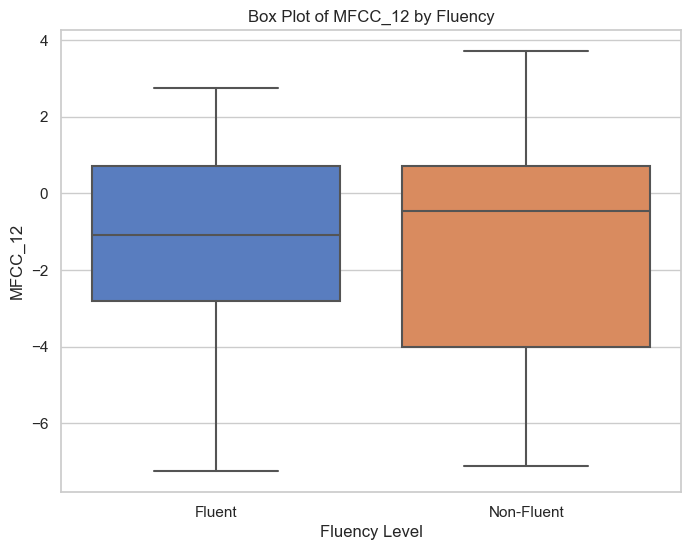

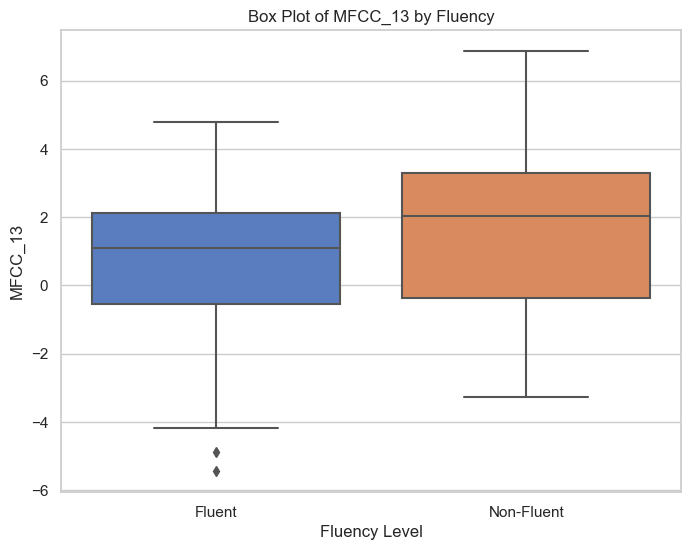

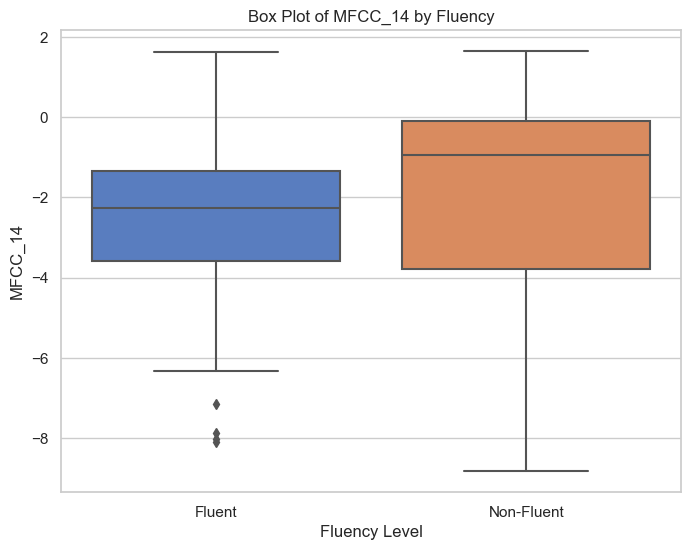

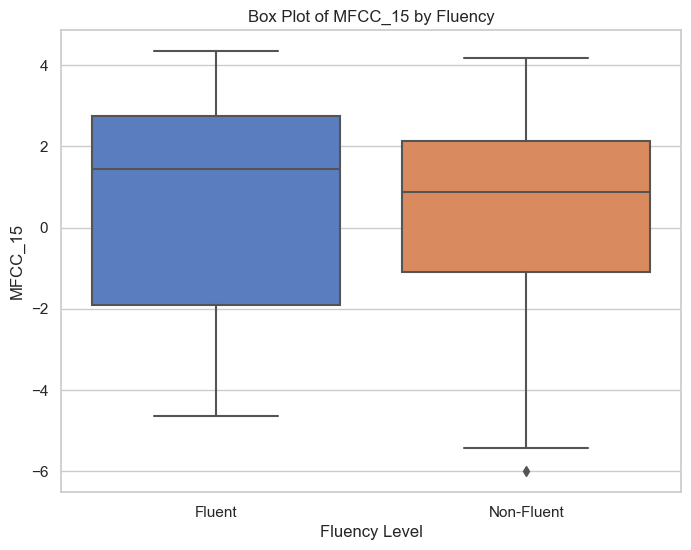

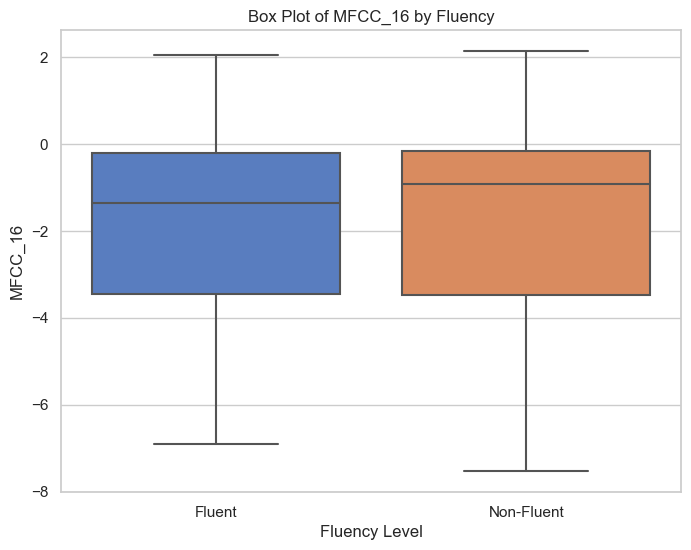

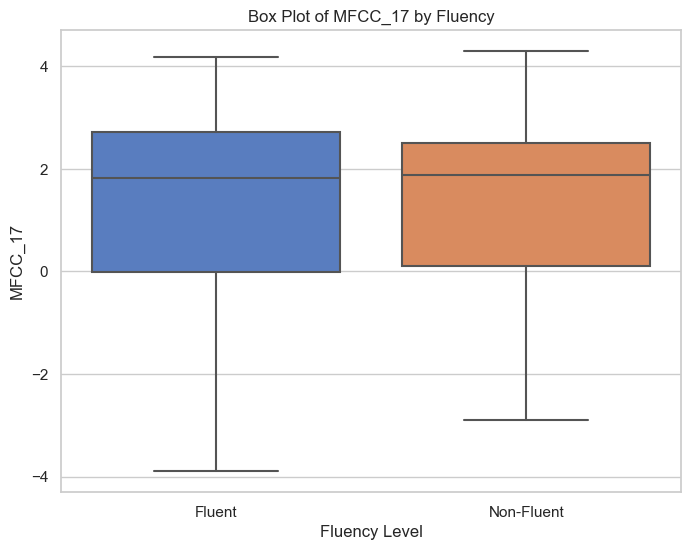

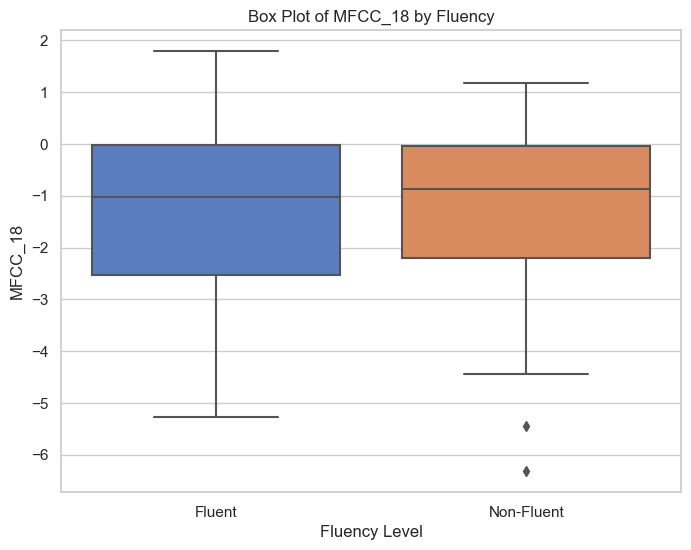

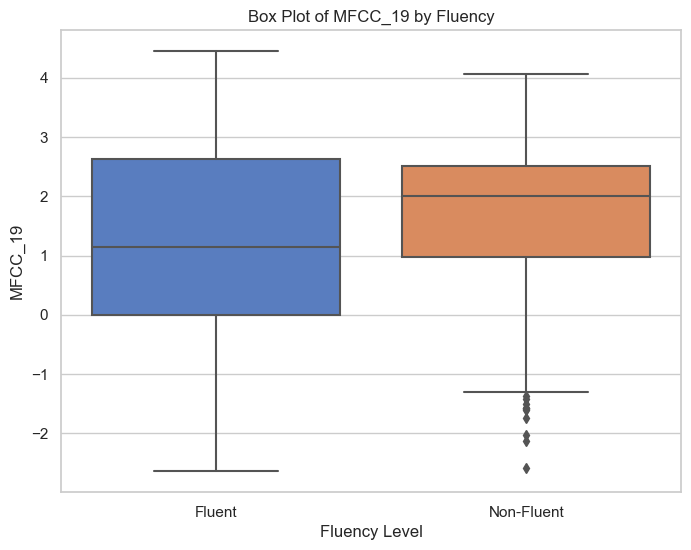

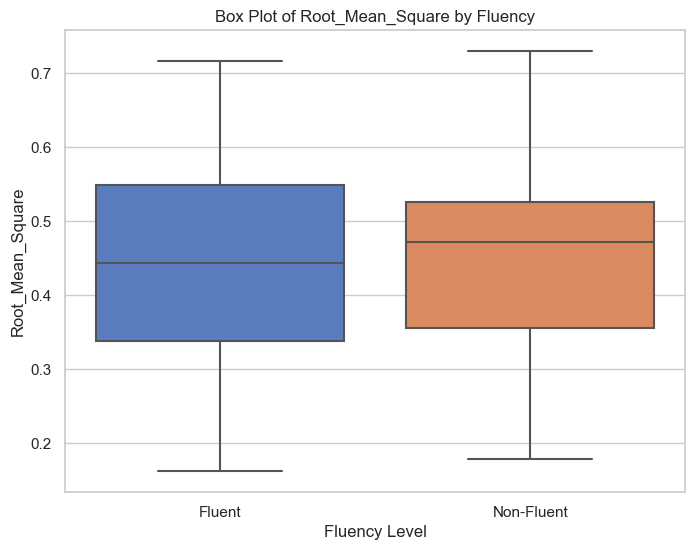

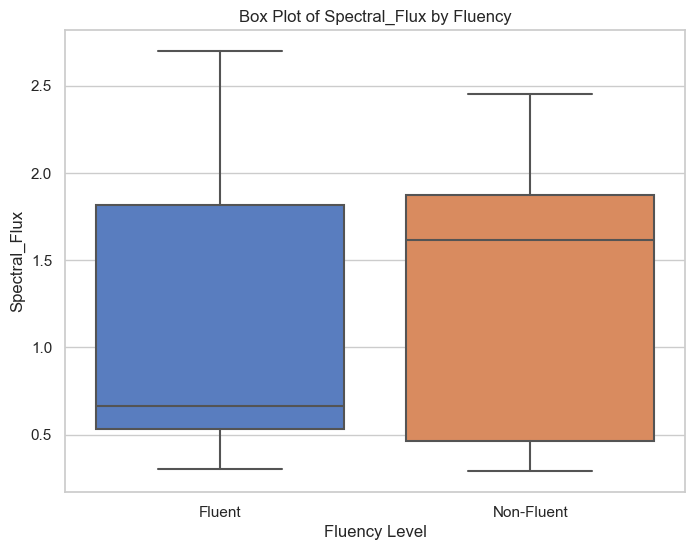

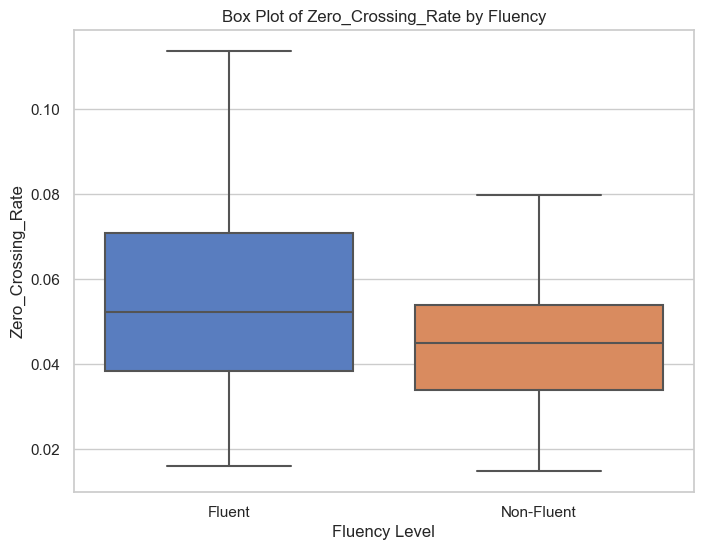

In [40]:
# Box plots for each feature
for feature in feature_names:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f'Box Plot of {feature} by Fluency')
    plt.xlabel('Fluency Level')
    plt.ylabel(f'{feature}')
    plt.show()


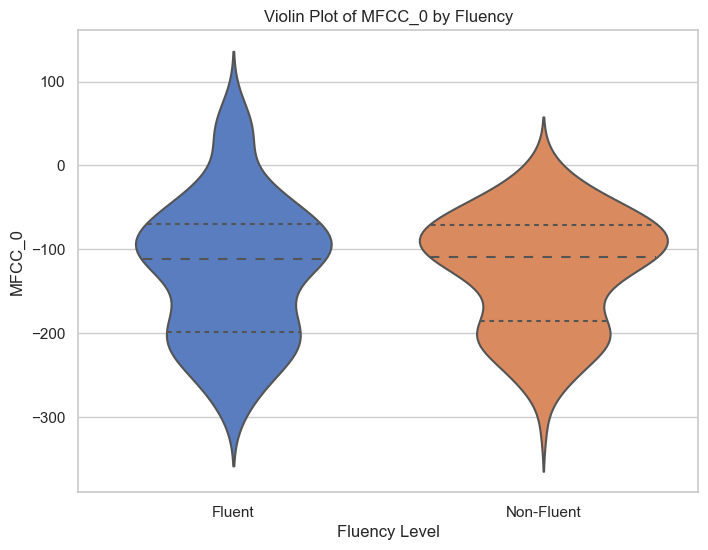

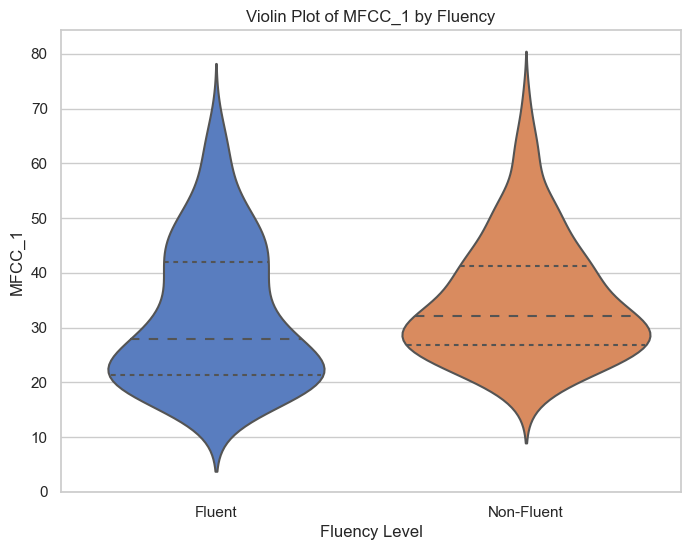

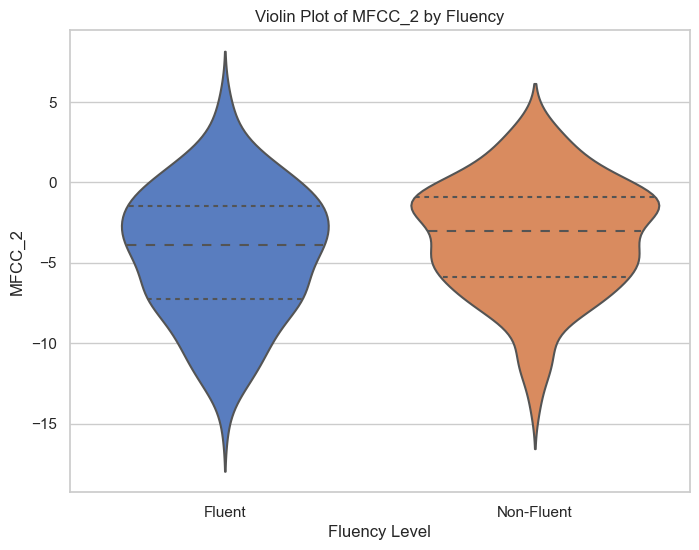

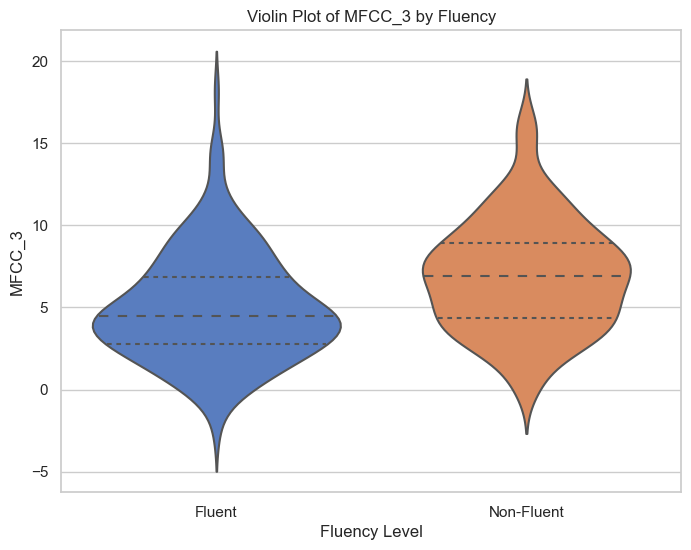

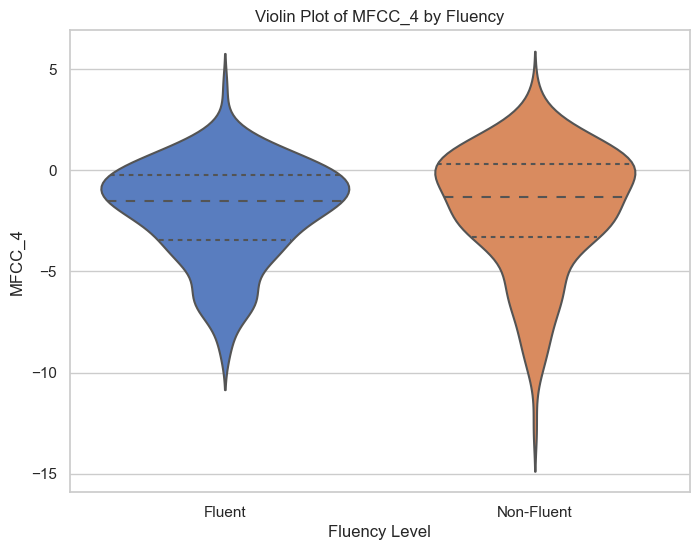

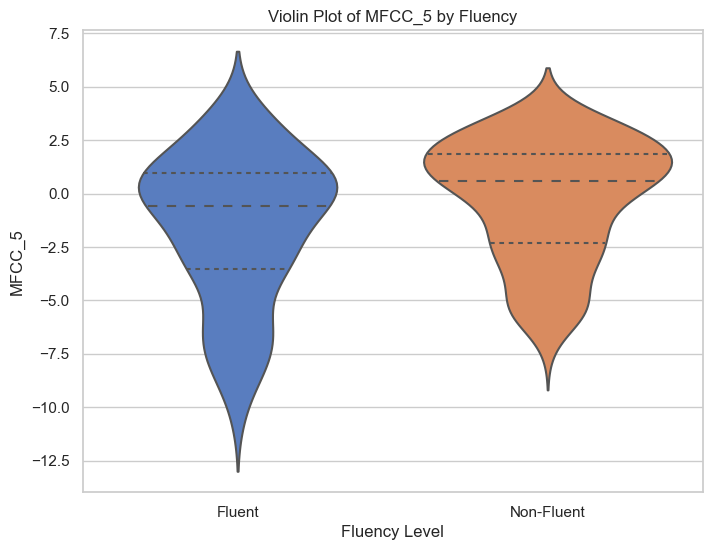

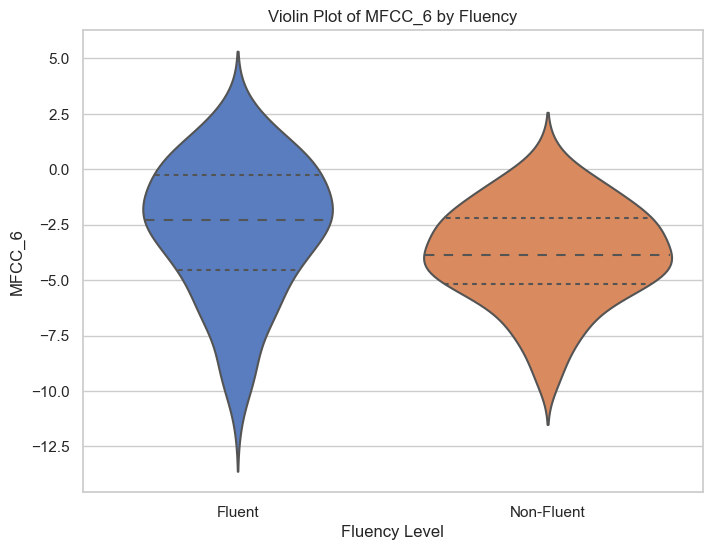

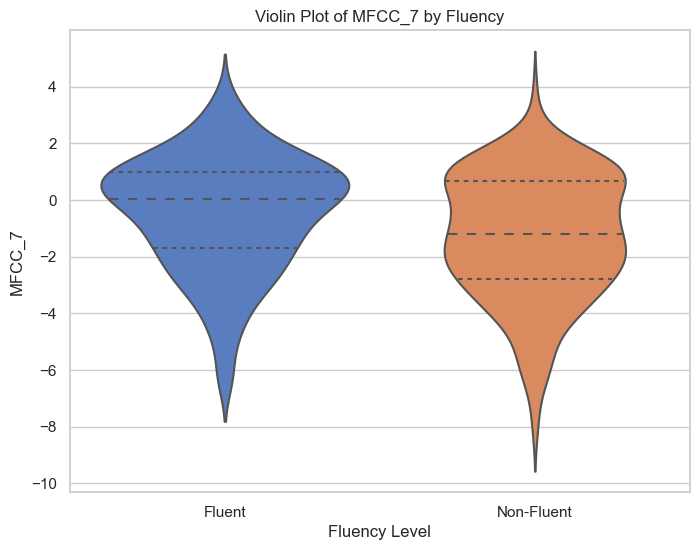

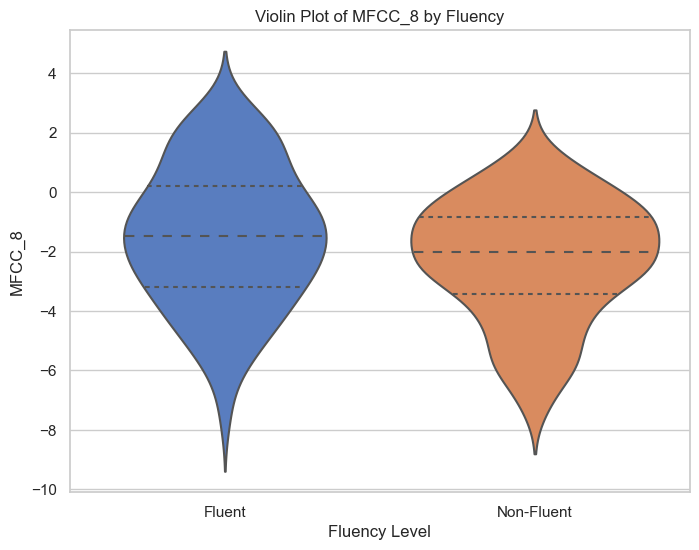

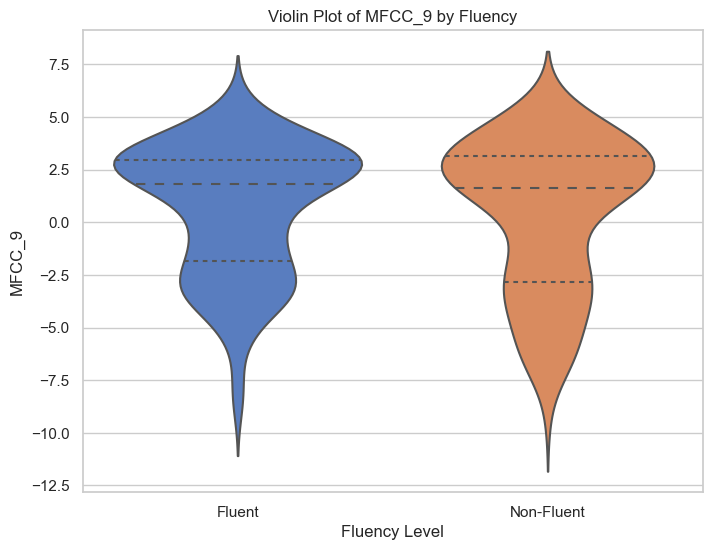

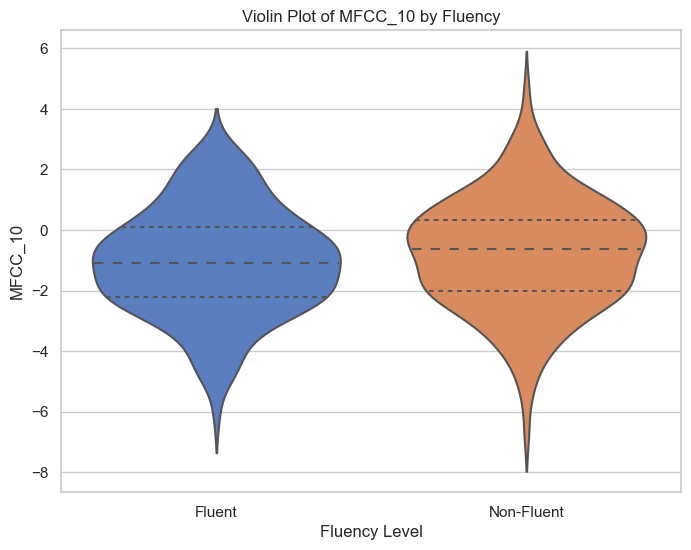

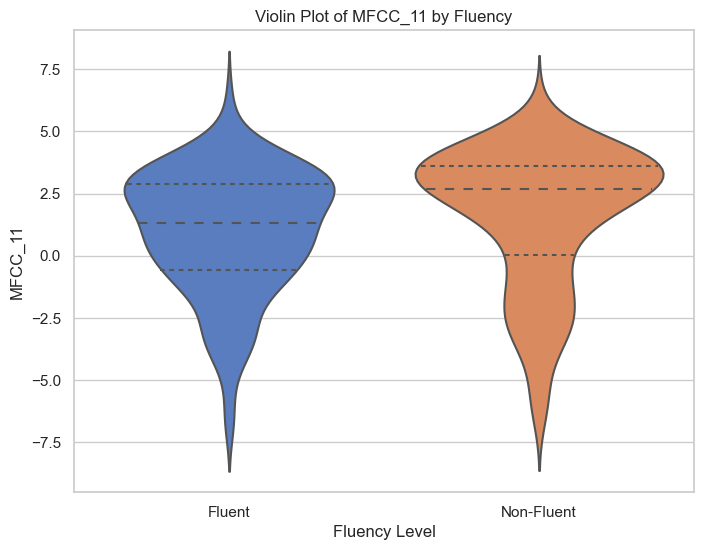

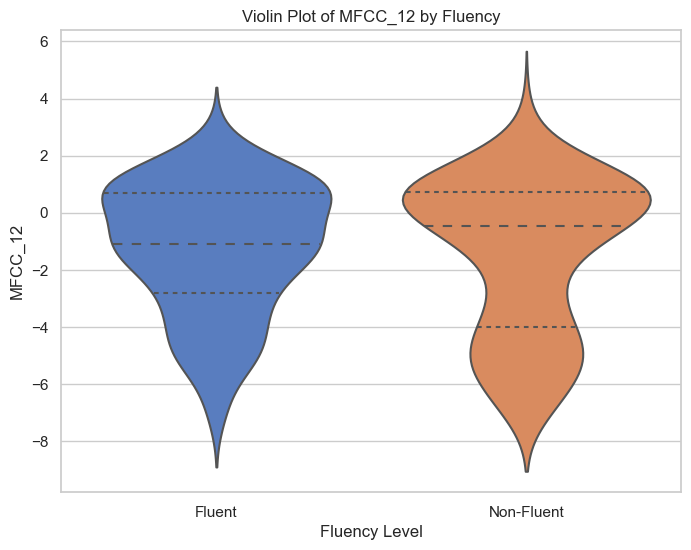

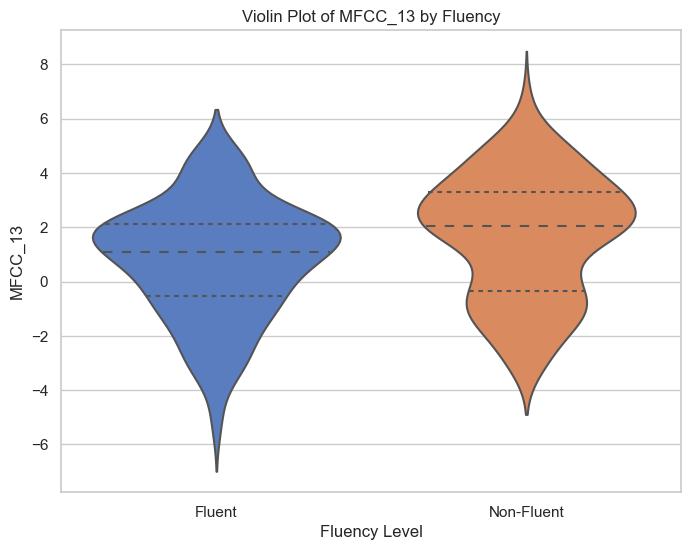

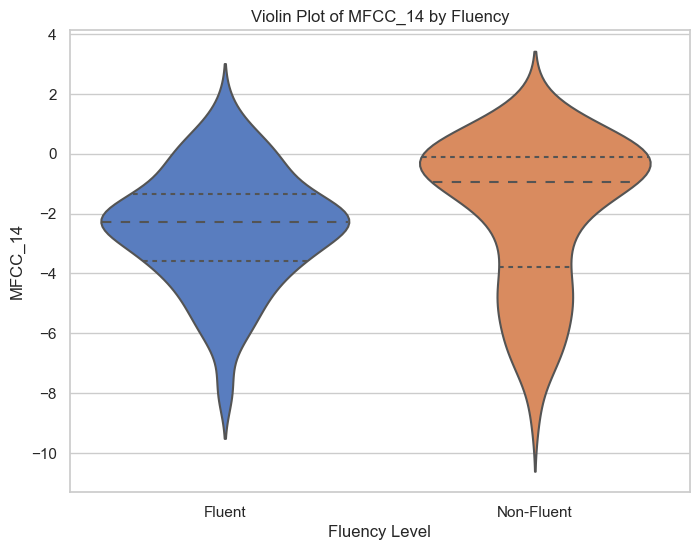

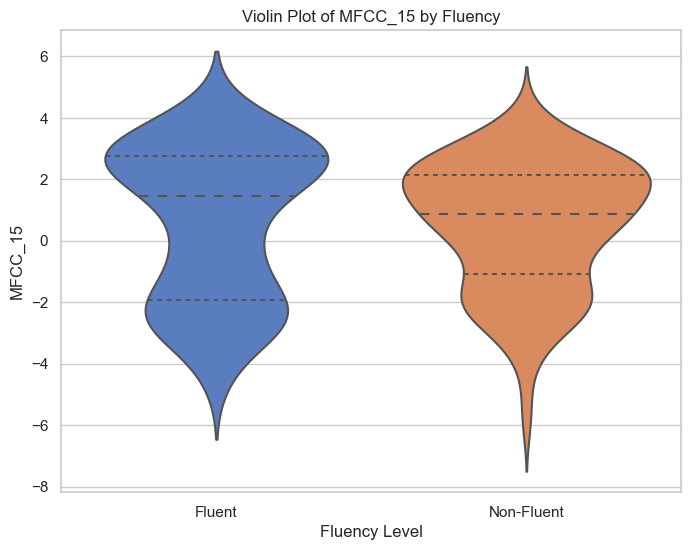

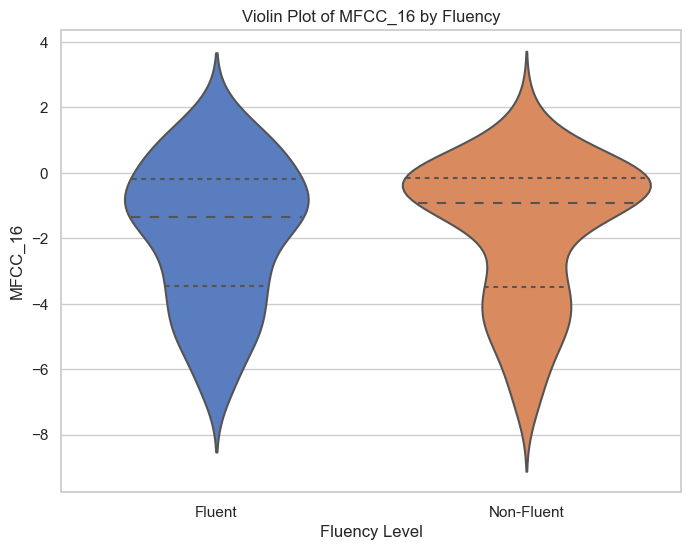

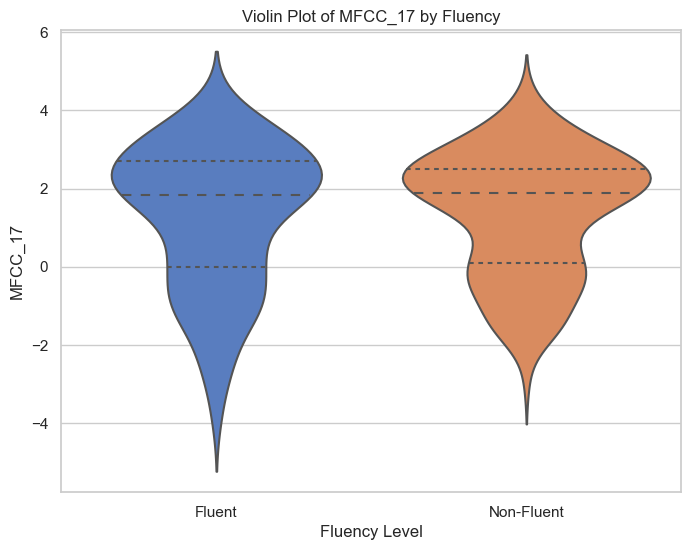

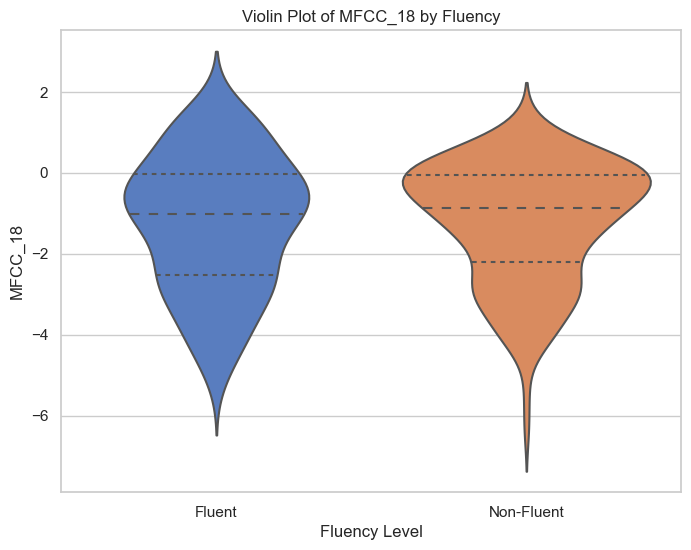

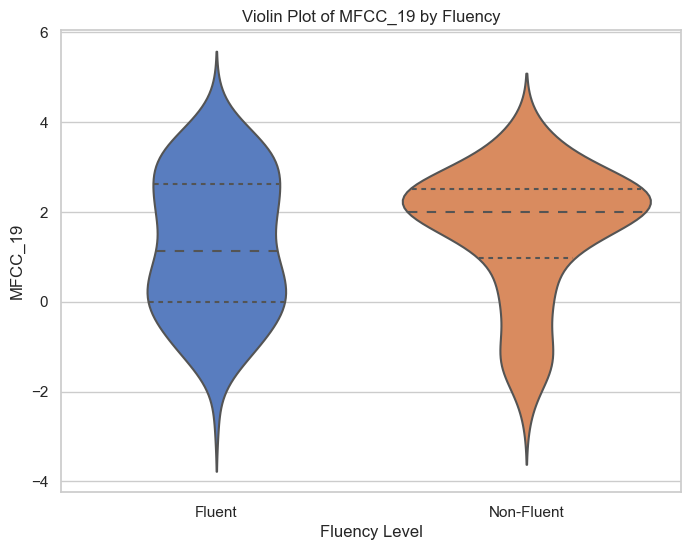

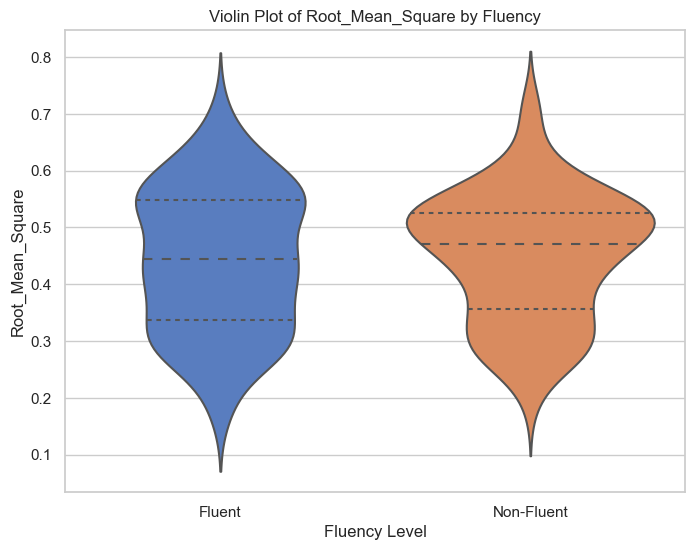

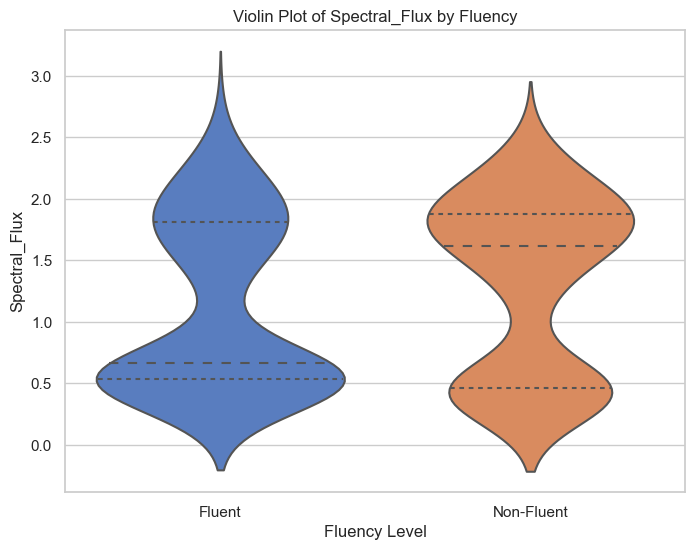

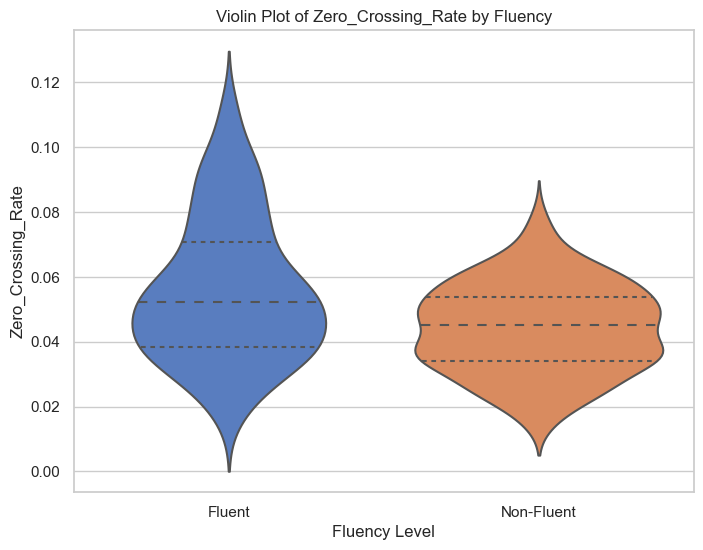

In [41]:
# Violin plots for each feature
for feature in feature_names:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Label', y=feature, data=df, inner='quartile')
    plt.title(f'Violin Plot of {feature} by Fluency')
    plt.xlabel('Fluency Level')
    plt.ylabel(f'{feature}')
    plt.show()


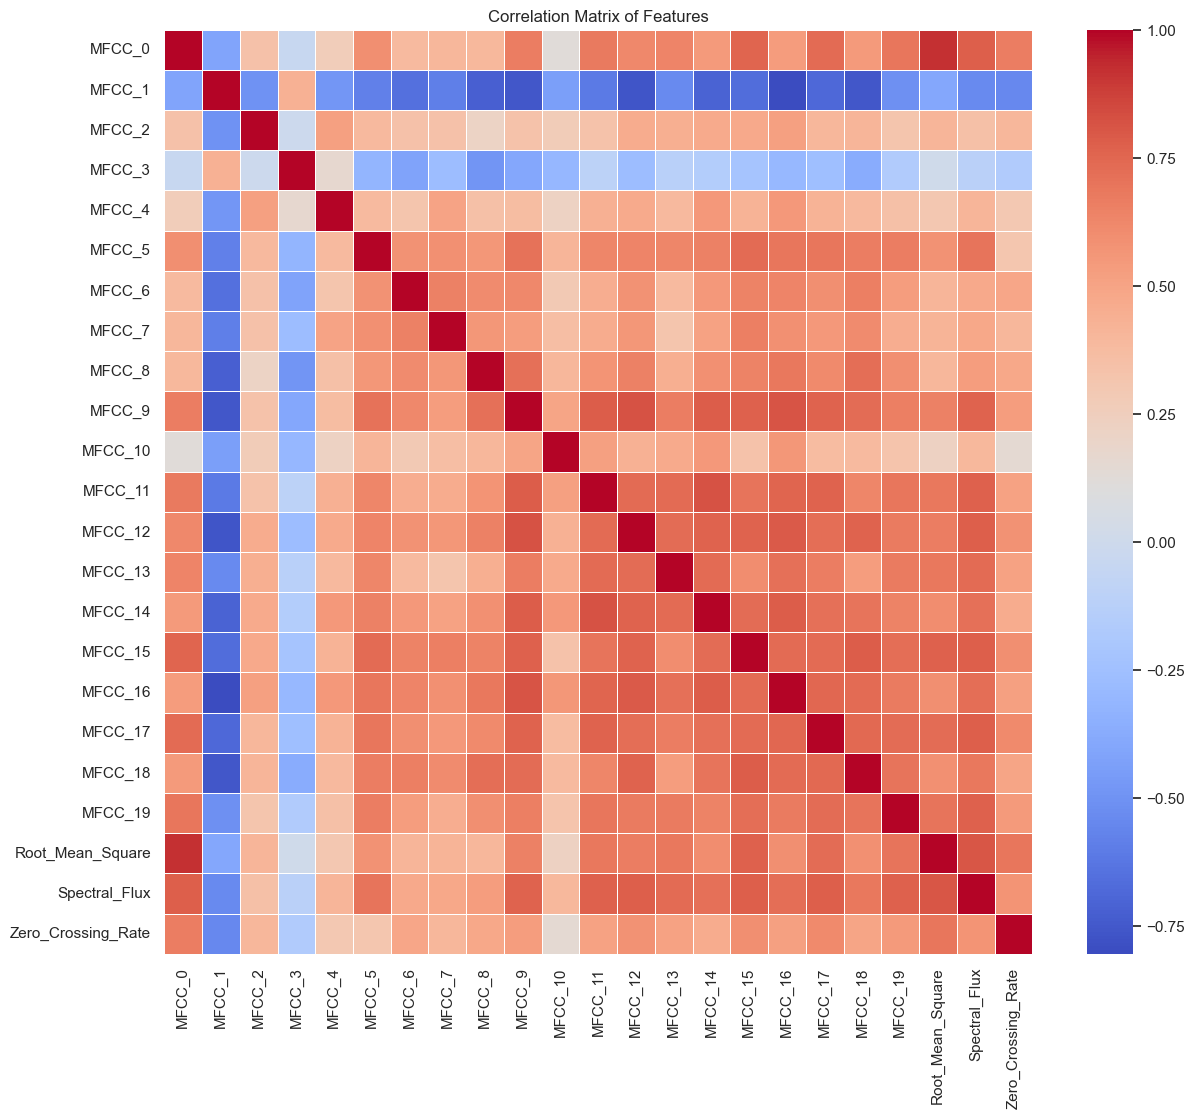

In [42]:
# Compute the correlation matrix
corr = df[feature_names].corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Separate the data into two groups
fluent = df[df['Label'] == 'Fluent']
non_fluent = df[df['Label'] == 'Non-Fluent']

# Perform t-tests
t_test_results = {}

for feature in feature_names:
    t_stat, p_value = ttest_ind(fluent[feature], non_fluent[feature], equal_var=False)  # Use Welch's t-test if variances are unequal
    t_test_results[feature] = {'t_stat': t_stat, 'p_value': p_value}

t_test_df = pd.DataFrame.from_dict(t_test_results, orient='index')
print(t_test_df)


                      t_stat       p_value
MFCC_0              0.127367  8.987346e-01
MFCC_1             -2.303497  2.191573e-02
MFCC_2             -2.361666  1.880722e-02
MFCC_3             -5.111261  5.483642e-07
MFCC_4             -0.387386  6.987281e-01
MFCC_5             -3.736765  2.233547e-04
MFCC_6              3.913597  1.138441e-04
MFCC_7              3.586563  3.865653e-04
MFCC_8              3.324310  9.926988e-04
MFCC_9              0.795978  4.266283e-01
MFCC_10            -1.344268  1.798007e-01
MFCC_11            -2.116489  3.506455e-02
MFCC_12             0.788878  4.307642e-01
MFCC_13            -3.680554  2.723771e-04
MFCC_14            -2.459316  1.445646e-02
MFCC_15             0.305783  7.599793e-01
MFCC_16            -0.410720  6.815501e-01
MFCC_17            -0.440774  6.596850e-01
MFCC_18            -0.178328  8.585809e-01
MFCC_19            -1.923775  5.527819e-02
Root_Mean_Square   -0.642371  5.211010e-01
Spectral_Flux      -2.624193  9.097215e-03
Zero_Crossi

In [ ]:
from scipy.stats import f_oneway

anova_results = {}

for feature in feature_names:
    F_stat, p_value = f_oneway(fluent[feature], non_fluent[feature])
    anova_results[feature] = {'F_stat': F_stat, 'p_value': p_value}

anova_df = pd.DataFrame.from_dict(anova_results, orient='index')
print(anova_df)


                       F_stat       p_value
MFCC_0               0.016482  8.979256e-01
MFCC_1               5.371282  2.109168e-02
MFCC_2               5.633543  1.820098e-02
MFCC_3              26.090091  5.564835e-07
MFCC_4               0.147577  7.011130e-01
MFCC_5              14.212494  1.939098e-04
MFCC_6              15.689208  9.177410e-05
MFCC_7              12.791624  4.010954e-04
MFCC_8              11.176418  9.251406e-04
MFCC_9               0.626388  4.292604e-01
MFCC_10              1.801336  1.804879e-01
MFCC_11              4.435427  3.596699e-02
MFCC_12              0.613530  4.340321e-01
MFCC_13             13.472806  2.828304e-04
MFCC_14              5.928511  1.543548e-02
MFCC_15              0.094884  7.582546e-01
MFCC_16              0.168736  6.815083e-01
MFCC_17              0.196601  6.577733e-01
MFCC_18              0.032116  8.578856e-01
MFCC_19              3.724604  5.448639e-02
Root_Mean_Square     0.416146  5.193216e-01
Spectral_Flux        6.878365  9

In [ ]:
from statsmodels.stats.multitest import multipletests

# Extract p-values from t-test results
p_values = [result['p_value'] for result in t_test_results.values()]

# Adjust p-values using the Benjamini-Hochberg method
adjusted_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

# Add adjusted p-values to the results
for i, feature in enumerate(t_test_results.keys()):
    t_test_results[feature]['adjusted_p_value'] = adjusted_p_values[i]

t_test_df = pd.DataFrame.from_dict(t_test_results, orient='index')
print(t_test_df)


                      t_stat       p_value  adjusted_p_value
MFCC_0              0.127367  8.987346e-01      8.987346e-01
MFCC_1             -2.303497  2.191573e-02      4.582379e-02
MFCC_2             -2.361666  1.880722e-02      4.325660e-02
MFCC_3             -5.111261  5.483642e-07      6.306188e-06
MFCC_4             -0.387386  6.987281e-01      8.035373e-01
MFCC_5             -3.736765  2.233547e-04      1.252935e-03
MFCC_6              3.913597  1.138441e-04      8.728046e-04
MFCC_7              3.586563  3.865653e-04      1.481834e-03
MFCC_8              3.324310  9.926988e-04      3.261725e-03
MFCC_9              0.795978  4.266283e-01      6.192235e-01
MFCC_10            -1.344268  1.798007e-01      2.953869e-01
MFCC_11            -2.116489  3.506455e-02      6.720706e-02
MFCC_12             0.788878  4.307642e-01      6.192235e-01
MFCC_13            -3.680554  2.723771e-04      1.252935e-03
MFCC_14            -2.459316  1.445646e-02      3.694429e-02
MFCC_15             0.30

In [ ]:
# Calculate Cohen's d for each feature
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * x.std() ** 2 + (ny - 1) * y.std() ** 2) / dof)
    return (x.mean() - y.mean()) / pooled_std

for feature in feature_names:
    d = cohen_d(fluent[feature], non_fluent[feature])
    t_test_results[feature]['cohen_d'] = d

t_test_df = pd.DataFrame.from_dict(t_test_results, orient='index')
print(t_test_df)


                      t_stat       p_value  adjusted_p_value   cohen_d
MFCC_0              0.127367  8.987346e-01      8.987346e-01  0.014210
MFCC_1             -2.303497  2.191573e-02      4.582379e-02 -0.256530
MFCC_2             -2.361666  1.880722e-02      4.325660e-02 -0.262718
MFCC_3             -5.111261  5.483642e-07      6.306188e-06 -0.565376
MFCC_4             -0.387386  6.987281e-01      8.035373e-01 -0.042522
MFCC_5             -3.736765  2.233547e-04      1.252935e-03 -0.417287
MFCC_6              3.913597  1.138441e-04      8.728046e-04  0.438430
MFCC_7              3.586563  3.865653e-04      1.481834e-03  0.395879
MFCC_8              3.324310  9.926988e-04      3.261725e-03  0.370042
MFCC_9              0.795978  4.266283e-01      6.192235e-01  0.087603
MFCC_10            -1.344268  1.798007e-01      2.953869e-01 -0.148558
MFCC_11            -2.116489  3.506455e-02      6.720706e-02 -0.233113
MFCC_12             0.788878  4.307642e-01      6.192235e-01  0.086700
MFCC_1

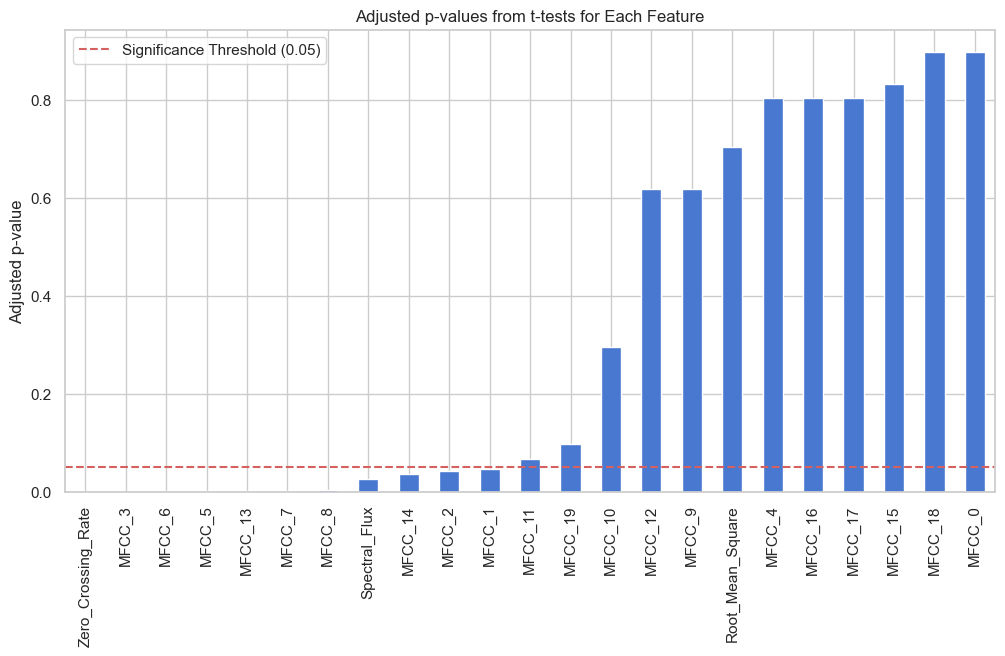

In [47]:
# Bar plot of adjusted p-values
plt.figure(figsize=(12, 6))
adjusted_p_values_series = pd.Series(adjusted_p_values, index=feature_names)
adjusted_p_values_series.sort_values(ascending=True, inplace=True)
adjusted_p_values_series.plot(kind='bar')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Adjusted p-values from t-tests for Each Feature')
plt.ylabel('Adjusted p-value')
plt.legend()
plt.show()


In [48]:
from scipy.stats import shapiro

normality_results = {}
for feature in feature_names:
    stat, p = shapiro(df[feature])
    normality_results[feature] = {'Shapiro-Wilk Stat': stat, 'p_value': p}

normality_df = pd.DataFrame.from_dict(normality_results, orient='index')
print(normality_df)


                    Shapiro-Wilk Stat       p_value
MFCC_0                       0.980745  2.262704e-04
MFCC_1                       0.945489  1.259490e-09
MFCC_2                       0.986017  2.949467e-03
MFCC_3                       0.979150  1.099462e-04
MFCC_4                       0.951445  6.445846e-09
MFCC_5                       0.943773  8.034164e-10
MFCC_6                       0.991988  7.483774e-02
MFCC_7                       0.972951  8.217927e-06
MFCC_8                       0.991858  6.962033e-02
MFCC_9                       0.919724  3.153329e-12
MFCC_10                      0.997592  9.181566e-01
MFCC_11                      0.927711  1.730254e-11
MFCC_12                      0.930095  2.945655e-11
MFCC_13                      0.985444  2.199680e-03
MFCC_14                      0.957596  3.975774e-08
MFCC_15                      0.944657  1.011836e-09
MFCC_16                      0.942061  5.173438e-10
MFCC_17                      0.946768  1.771241e-09
MFCC_18     

In [49]:
from scipy.stats import levene

variance_results = {}
for feature in feature_names:
    stat, p = levene(fluent[feature], non_fluent[feature])
    variance_results[feature] = {'Levene Stat': stat, 'p_value': p}

variance_df = pd.DataFrame.from_dict(variance_results, orient='index')
print(variance_df)


                    Levene Stat   p_value
MFCC_0                 5.617533  0.018365
MFCC_1                 5.068692  0.025029
MFCC_2                 2.427096  0.120227
MFCC_3                 0.583339  0.445561
MFCC_4                 4.981304  0.026304
MFCC_5                 5.315731  0.021763
MFCC_6                12.169992  0.000553
MFCC_7                 1.984958  0.159825
MFCC_8                 3.792414  0.052346
MFCC_9                 2.089536  0.149275
MFCC_10                0.177437  0.673864
MFCC_11                0.390258  0.532602
MFCC_12                5.032804  0.025545
MFCC_13                1.248097  0.264741
MFCC_14                7.385872  0.006926
MFCC_15               11.262523  0.000885
MFCC_16                0.287765  0.592024
MFCC_17                2.192825  0.139624
MFCC_18                3.172355  0.075828
MFCC_19                7.864333  0.005345
Root_Mean_Square       3.988065  0.046657
Spectral_Flux          0.000528  0.981681
Zero_Crossing_Rate    24.047129  0

In [50]:
from scipy.stats import mannwhitneyu

non_parametric_results = {}

for feature in feature_names:
    stat, p_value = mannwhitneyu(fluent[feature], non_fluent[feature], alternative='two-sided')
    non_parametric_results[feature] = {'U_stat': stat, 'p_value': p_value}

non_parametric_df = pd.DataFrame.from_dict(non_parametric_results, orient='index')
print(non_parametric_df)


                     U_stat       p_value
MFCC_0              13165.0  8.335451e-01
MFCC_1              10625.0  1.452719e-03
MFCC_2              11461.0  2.744111e-02
MFCC_3               8900.0  1.954844e-07
MFCC_4              12374.0  2.558508e-01
MFCC_5              10276.0  3.274295e-04
MFCC_6              17012.0  1.765090e-05
MFCC_7              16226.0  7.449888e-04
MFCC_8              15819.0  3.780105e-03
MFCC_9              13822.0  5.769250e-01
MFCC_10             12121.0  1.520114e-01
MFCC_11             10617.0  1.406408e-03
MFCC_12             13534.0  8.253306e-01
MFCC_13             10097.0  1.434492e-04
MFCC_14             10213.0  2.460541e-04
MFCC_15             14178.0  3.297172e-01
MFCC_16             12713.0  4.596917e-01
MFCC_17             13352.0  9.939280e-01
MFCC_18             13080.0  7.568087e-01
MFCC_19             11655.0  4.792289e-02
Root_Mean_Square    12976.0  6.661510e-01
Spectral_Flux       12513.0  3.302985e-01
Zero_Crossing_Rate  17307.0  3.516

### PCA of lips

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

LOAD_DIR = 'data/processed/'
data = np.load(LOAD_DIR + 'landmarks.npy')
# Extract lip landmarks
lip_landmarks = data[:, :, :, 48:68]

# Reshape the data for PCA
# combine samples and frames into one dimension
num_samples = lip_landmarks.shape[0] * lip_landmarks.shape[1]
lip_data = lip_landmarks.reshape(num_samples, 3 * 20)  # Shape: (81750, 60)

# Standardize the data (mean centering)
lip_data_mean = np.mean(lip_data, axis=0)
lip_data_centered = lip_data - lip_data_mean

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(lip_data_centered)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)

Explained variance ratio: [0.79555686 0.1831575  0.00954098]


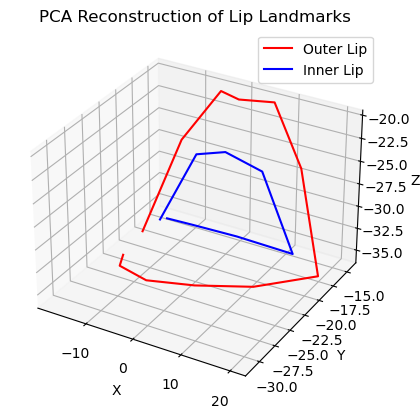

In [ ]:
# Reconstruct landmarks from principal components
reconstructed_data = pca.inverse_transform(principal_components)

# Select the first sample for visualization
sample_index = 0  # Modify as needed
frame_index = 0   # Modify as needed

# Get the reconstructed landmarks
reconstructed_landmarks = reconstructed_data.reshape(num_samples, 3, 20)
reconstructed_landmarks = reconstructed_landmarks[sample_index * lip_landmarks.shape[1] + frame_index]

# Original mean landmarks for adding back the mean
mean_landmarks = lip_data_mean.reshape(3, 20)

# Add the mean back to the reconstructed data
reconstructed_landmarks += mean_landmarks

outer_lip_indices = np.arange(12)
inner_lip_indices = np.arange(12, 20)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Outer lip
ax.plot(reconstructed_landmarks[0, outer_lip_indices], 
        reconstructed_landmarks[1, outer_lip_indices], 
        reconstructed_landmarks[2, outer_lip_indices], 
        color='red', label='Outer Lip')

# Inner lip
ax.plot(reconstructed_landmarks[0, inner_lip_indices], 
        reconstructed_landmarks[1, inner_lip_indices], 
        reconstructed_landmarks[2, inner_lip_indices], 
        color='blue', label='Inner Lip')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('PCA Reconstruction of Lip Landmarks')
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objects as go

LOAD_DIR = 'data/processed/'
data = np.load(LOAD_DIR + 'landmarks.npy')
lip_landmarks = data[:, :, :, 48:68]
num_samples = lip_landmarks.shape[0] * lip_landmarks.shape[1]
lip_data = lip_landmarks.reshape(num_samples, 3 * 20)  # Shape: (81750, 60)

lip_data_mean = np.mean(lip_data, axis=0)
lip_data_centered = lip_data - lip_data_mean

pca = PCA(n_components=3)
principal_components = pca.fit_transform(lip_data_centered)

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)

# Reconstruct landmarks from principal components
reconstructed_data = pca.inverse_transform(principal_components)

# Select the first sample and frame for visualization
sample_index = 0 
frame_index = 0  

# Calculate the index in the reshaped data
data_index = sample_index * lip_landmarks.shape[1] + frame_index

# Get the reconstructed landmarks for the selected sample and frame
reconstructed_landmarks = reconstructed_data[data_index].reshape(3, 20)

# Add the mean back to the reconstructed data
reconstructed_landmarks += lip_data_mean.reshape(3, 20)

x_coords = reconstructed_landmarks[0]
y_coords = reconstructed_landmarks[1]
z_coords = reconstructed_landmarks[2]

outer_lip_indices = np.array([i for i in range(12)] + [0])
inner_lip_indices = np.array([i for i in range(12, 20)] + [12])

fig = go.Figure()

# Plot the outer lip
fig.add_trace(go.Scatter3d(
    x=x_coords[outer_lip_indices],
    y=y_coords[outer_lip_indices],
    z=z_coords[outer_lip_indices],
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(size=5),
    name='Outer Lip',
    hoverinfo='skip'
))

# Plot the inner lip
fig.add_trace(go.Scatter3d(
    x=x_coords[inner_lip_indices],
    y=y_coords[inner_lip_indices],
    z=z_coords[inner_lip_indices],
    mode='lines+markers',
    line=dict(color='blue', width=4),
    marker=dict(size=5),
    name='Inner Lip',
    hoverinfo='skip'
))

fig.update_layout(
    title='Interactive 3D PCA Reconstruction of Lip Landmarks',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    legend=dict(
        x=0.8,
        y=0.9
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()


Explained variance ratio: [0.79555686 0.18315784 0.00954099]


MORE!

In [ ]:
# Mean shape (mean of the original lip data)
mean_shape = lip_data_mean.reshape(3, 20)


In [ ]:
# Standard deviations along principal components
std_devs = np.sqrt(pca.explained_variance_)


In [ ]:
num_pcs = 3
variations = []

for pc_index in range(num_pcs):
    principal_axis = pca.components_[pc_index]
    
    # Standard deviation along this principal component
    std_dev = std_devs[pc_index]
    
    # Create variations at -2SD, -1SD, Mean, +1SD, +2SD
    for multiplier in [-2, -1, 0, 1, 2]:
        variation = mean_shape.flatten() + multiplier * std_dev * principal_axis
        variation = variation.reshape(3, 20)
        variations.append({
            'pc_index': pc_index + 1,
            'multiplier': multiplier,
            'landmarks': variation
        })


In [ ]:
outer_lip_indices = np.array([i for i in range(12)] + [0])
inner_lip_indices = np.array([i for i in range(12, 20)] + [12])


In [ ]:
import plotly.graph_objects as go

def plot_lip_landmarks(landmarks, title):
    x_coords = landmarks[0]
    y_coords = landmarks[1]
    z_coords = landmarks[2]
    
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=x_coords[outer_lip_indices],
        y=y_coords[outer_lip_indices],
        z=z_coords[outer_lip_indices],
        mode='lines+markers',
        line=dict(color='red', width=4),
        marker=dict(size=5),
        name='Outer Lip',
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter3d(
        x=x_coords[inner_lip_indices],
        y=y_coords[inner_lip_indices],
        z=z_coords[inner_lip_indices],
        mode='lines+markers',
        line=dict(color='blue', width=4),
        marker=dict(size=5),
        name='Inner Lip',
        hoverinfo='skip'
    ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="X Coordinate", showgrid=False, zeroline=False, visible=False),
            yaxis=dict(title="Y Coordinate", showgrid=False, zeroline=False, visible=False),
            zaxis=dict(title="Z Coordinate", showgrid=False, zeroline=False, visible=False),
            camera=dict(eye=dict(x=0, y=0, z=2)),
            aspectmode='data'
        ),
        legend=dict(
            x=0.8,
            y=0.9
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )
    
    fig.show()


In [ ]:
# Iterate and plot
for variation in variations:
    pc = variation['pc_index']
    multiplier = variation['multiplier']
    landmarks = variation['landmarks']
    if multiplier == 0:
        title = f'Principal Component {pc}: Mean Shape'
    else:
        sd = f'{abs(multiplier)} SD'
        direction = 'Above' if multiplier > 0 else 'Below'
        title = f'Principal Component {pc}: Mean {direction} by {sd}'
    plot_lip_landmarks(landmarks, title)
